# Introdução

## Modelo XGBoost

Neste notebook, foi construído um pipeline completo de modelagem para detecção automática de falhas em chapas de aço inoxidável, com foco na robustez, reprodutibilidade e performance.

### Etapas realizadas:
- Pré-processamento de dados com imputação, normalização e codificação categórica.
- Engenharia de atributos para enriquecer o conjunto de features com variáveis compostas.
- Remoção de outliers por classe com base no intervalo interquartil (IQR).
- Balanceamento das classes com a técnica de oversampling SMOTE.
- Treinamento de um modelo do tipo XGBoost, com hiperparâmetros ajustados.
- Validação com divisão estratificada e avaliação com a métrica F1-score macro, adequada para problemas com desbalanceamento de classes.
- Geração de previsões e conversão para o formato binário exigido, com exportação final em CSV.

### Justificativa da abordagem:
O problema foi tratado como classificação multiclasses, já que cada amostra do conjunto de dados está associada a exatamente uma falha. A modelagem multirrótulo foi descartada após análise do campo soma_defeitos, onde todas as linhas apresentavam valor 1.

### Métrica escolhida:
A métrica principal de avaliação foi o F1-score macro, pois ela considera o desempenho de todas as classes igualmente, mesmo em situações de desbalanceamento, o que é crítico neste cenário industrial, onde falhas menos frequentes também precisam ser detectadas com precisão.

### Impacto do modelo:
Um sistema de classificação como este pode automatizar o controle de qualidade na indústria siderúrgica, reduzindo falhas humanas, custos com retrabalho e perdas de material, além de aumentar a rastreabilidade do processo.

---

Arquivo de submissão final gerado com sucesso. Pode consultar o resultado na pasta de outputs ou no README.md


# Modelo

Classificação com XGBoost:
              precision    recall  f1-score   support

           0       0.47      0.49      0.48        43
           1       0.88      0.90      0.89        42
           2       1.00      1.00      1.00       100
           3       0.88      1.00      0.93        14
           4       0.53      0.50      0.52        16
           5       0.56      0.67      0.61       124
           6       0.67      0.56      0.61       178

    accuracy                           0.70       517
   macro avg       0.71      0.73      0.72       517
weighted avg       0.71      0.70      0.70       517



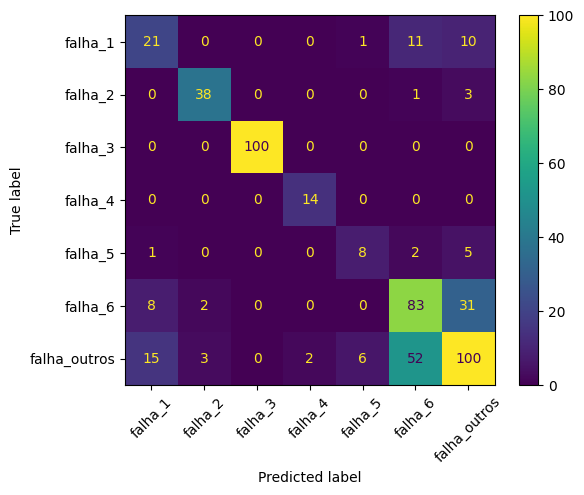

In [4]:
from xgboost import XGBClassifier               # Modelo XGBoost para classificação
import numpy as np                              # Biblioteca para operações numéricas
import pandas as pd                             # Leitura e manipulação de dados tabulares
import matplotlib.pyplot as plt                 # Visualização de gráficos

# Ferramentas do Scikit-learn
from sklearn.model_selection import train_test_split       # Divisão treino/teste
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder  # Pré-processamento
from sklearn.compose import ColumnTransformer              # Aplicar transformação por tipo de coluna
from sklearn.pipeline import Pipeline                      # Encadeamento de passos de transformação
from sklearn.impute import SimpleImputer                   # Imputação de valores ausentes
from sklearn.metrics import classification_report          # Métricas de avaliação do modelo

# Para balanceamento de classes e pipeline integrado
from imblearn.over_sampling import SMOTE                   # Técnica de oversampling para classes minoritárias
from imblearn.pipeline import Pipeline as ImbPipeline      # Pipeline que aceita SMOTE

# Colunas que irei remover os outliers, remover de mais colunas reduzia muito a amostra.
top_features_outliers = [
    'perimetro_x',
    'log_das_areas',
    'indice_de_variacao_x',
    'log_indice_y',
    'log_indice_x'
]

# Remove as linhas que fogem do IQR nas colunas que foram especificadas acima
def remover_outliers_iqr(df, colunas):
    df_filtrado = df.copy()
    for col in colunas:
        q1 = df_filtrado[col].quantile(0.25)
        q3 = df_filtrado[col].quantile(0.75)
        iqr = q3 - q1
        limite_inf = q1 - 1.5 * iqr
        limite_sup = q3 + 1.5 * iqr
        df_filtrado = df_filtrado[
            (df_filtrado[col] >= limite_inf) &
            (df_filtrado[col] <= limite_sup)
        ]
    return df_filtrado

# Faz a remoção dos outliers para cada classe, evitando viés por volume de dados
def remover_outliers_por_classe(df, colunas, classe_col):
    df_filtrado = pd.DataFrame()
    for classe in df[classe_col].unique():
        df_classe = df[df[classe_col] == classe]
        df_classe_filtrado = remover_outliers_iqr(df_classe, colunas)
        df_filtrado = pd.concat([df_filtrado, df_classe_filtrado])
    return df_filtrado

# Carregamento dos dados
df = pd.read_csv('C:/Users/natha/Downloads/RES_IA/outputs/chapa-treino.csv')

# Criação da coluna classe_defeito, vai ser a nossa variável target
colunas_falha = ['falha_1', 'falha_2', 'falha_3', 'falha_4', 'falha_5', 'falha_6', 'falha_outros']
if 'classe_defeito' not in df.columns:
    df['classe_defeito'] = df[colunas_falha].idxmax(axis=1)

# Garantindo que os valores estão no tipo correto
for col in colunas_falha:
    df[col] = df[col].astype(int)

# Criando novas features para representar razões e combinações que podem melhorar o modelo
df['razao_area_perimetro'] = df['area_pixels'] / (df['perimetro_x'] + df['perimetro_y'] + 1)
df['razao_luminosidade'] = df['maximo_da_luminosidade'] / (df['minimo_da_luminosidade'] + 1)
df['indice_log_produto'] = df['log_indice_x'] * df['log_indice_y']
df['razao_variacao'] = df['indice_de_variacao_x'] / (df['indice_de_variacao_y'] + 1)
df['bordas_y_alto'] = (df['indice_de_bordas_y'] > 0.95).astype(int)

# Removendo os outliers por classe
df_limpo = remover_outliers_por_classe(df, top_features_outliers, 'classe_defeito')

# Separação entre X (features) e y (rótulo)
X = df_limpo.drop(columns=colunas_falha + ['classe_defeito'])
y = df_limpo['classe_defeito']

# Códificação do rótulo, transforma os nomes em inteiros
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Identificação das colunas númericas e categóricas
numericas = X.select_dtypes(include='number').columns.tolist()
categoricas = X.select_dtypes(include='object').columns.tolist()

# Divisão treino/teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Pipelines de pré-processamento
numerico = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorico = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessador = ColumnTransformer([
    ('num', numerico, numericas),
    ('cat', categorico, categoricas)
])

# Definição do pipeline de modelagem com XGBoost + SMOTE
melhor_xgb = ImbPipeline(steps=[
    ('preprocessador', preprocessador), # Transforma dados
    ('smote', SMOTE(random_state=42)), # Balanceia classes de treino
    ('classificador', XGBClassifier( # Modelo de classificação XGBoost com hiperparâmetros otimizados
      objective='multi:softprob',
      eval_metric='mlogloss',
      n_estimators=312,
      learning_rate=0.092,
      max_depth=8,
      subsample=0.735,
      colsample_bytree=0.798,
      gamma=0.058,
      reg_alpha=0.888,
      reg_lambda=0.351,
      random_state=42
    ))
])

melhor_xgb.fit(X_train, y_train) # Treinamento do modelo
y_pred = melhor_xgb.predict(X_test) # Predição

# Imprime métricas como precisão, recall, F1-score por classe
print("Classificação com XGBoost:")
print(classification_report(y_test, y_pred))

# Matriz de confusão, visualiza onde o modelo está acertando ou errando mais
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(xticks_rotation=45)

In [5]:
## Esse bloco serve para otimizar automaticamente o desempenho do seu modelo, testando várias configurações do XGBClassifier
#
# from sklearn.model_selection import RandomizedSearchCV # faz busca aleatória em um espaço de hiperparâmetros 
# from sklearn.model_selection import StratifiedKFold # separa os dados em folds mantendo a proporção das classes

# from scipy.stats import uniform, randint # Distribuições de onde os valores dos hiperparâmetros serão amostrados aleatoriamente (uniforme e inteiros aleatórios).

# param_dist = { # Define quais hiperparâmetros do XGBoost serão testados e os intervalos de valores
#     'classificador__n_estimators': randint(150, 500), # nº de árvores (150 a 500)
#     'classificador__max_depth': randint(4, 12), # profundidade máxima da árvore
#     'classificador__learning_rate': uniform(0.01, 0.15), # taxa de aprendizado (de 0.01 a 0.16)
#     'classificador__subsample': uniform(0.7, 0.3), # regularizações
#     'classificador__colsample_bytree': uniform(0.6, 0.4), # regularizações
#     'classificador__gamma': uniform(0, 1), # regularizações
#     'classificador__reg_alpha': uniform(0, 1), # frações de amostragem
#     'classificador__reg_lambda': uniform(0, 1) # frações de amostragem
# }

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Divide o dataset em 5 partes (folds), garantindo que cada uma mantenha a proporção das classes. O shuffle=True garante embaralhamento antes de dividir.

# busca = RandomizedSearchCV(
#     melhor_xgb,
#     param_distributions=param_dist,
#     n_iter=75,                    # Executa até 75 combinações aleatórias dos parâmetros definidos
#     scoring='f1_weighted',        #  métrica usada para avaliar o modelo (mais justa para classes desbalanceadas)
#     cv=cv,                        # usa para validação cruzada
#     verbose=1,                    
#     random_state=42,
#     n_jobs=-1                     # usa todos os núcleos do processador para acelerar o processo
# )

# busca.fit(X_train, y_train)       # Treina e avalia 75 modelos diferentes com diferentes hiperparâmetros

# print("Melhores parâmetros:", busca.best_params_) # Mostra a combinação de parâmetros que gerou o melhor desempenho

## #Melhores parâmetros: {'classificador__colsample_bytree': np.float64(0.7977681218810326), 'classificador__gamma': np.float64(0.057558760016644284), 'classificador__learning_rate': np.float64(0.09242933234856032), 'classificador__max_depth': 8, 'classificador__n_estimators': 312, 'classificador__reg_alpha': np.float64(0.8877041827582998), 'classificador__reg_lambda': np.float64(0.3509150125520787), 'classificador__subsample': np.float64(0.7351201049282817)}

In [6]:
from sklearn.model_selection import cross_val_score # Importa a função de validação cruzada

scores = cross_val_score(melhor_xgb, X, y, scoring='f1_macro', cv=5) # Executa validação cruzada
print(f"F1 Macro Médio: {scores.mean():.4f} ± {scores.std():.4f}") # Retorna a médis dos F1-scores, desvio padrão e formata com 4 casas decimais

F1 Macro Médio: 0.7112 ± 0.0519


<Figure size 1200x600 with 0 Axes>

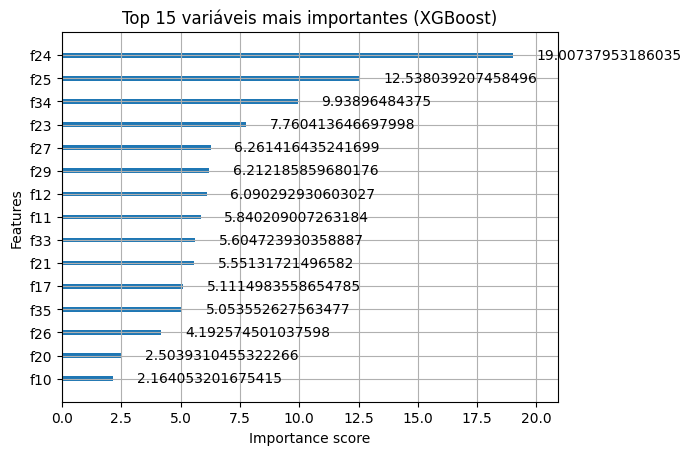

In [7]:
from xgboost import plot_importance

modelo_treinado = melhor_xgb.named_steps['classificador']

# Plot da importância das variáveis
plt.figure(figsize=(12, 6))
plot_importance(modelo_treinado, max_num_features=15, importance_type='gain')
plt.title("Top 15 variáveis mais importantes (XGBoost)")
plt.show()

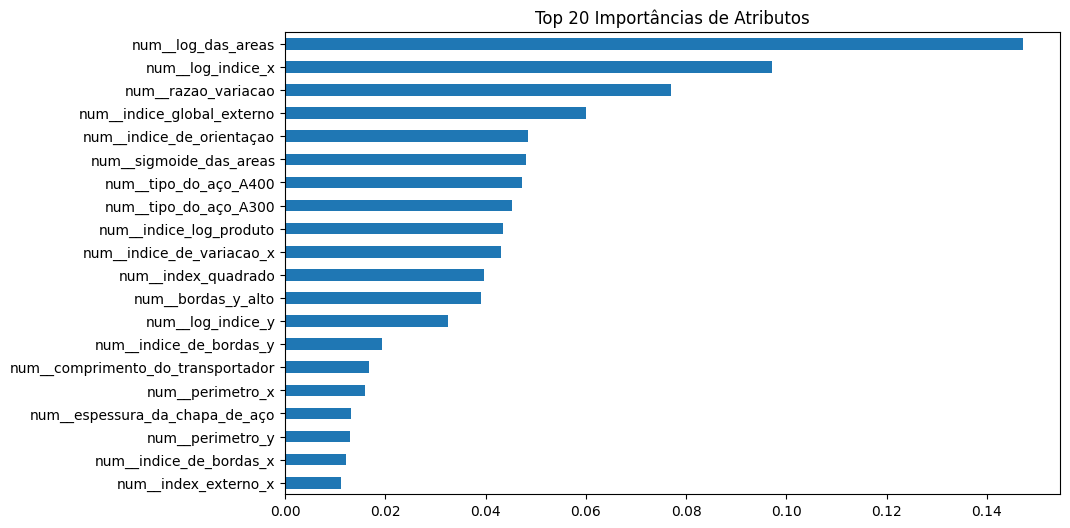

In [8]:
import matplotlib.pyplot as plt

modelo_final = melhor_xgb.named_steps['classificador']
importancias = modelo_final.feature_importances_
nomes_colunas = melhor_xgb.named_steps['preprocessador'].get_feature_names_out()

importancias_df = pd.Series(importancias, index=nomes_colunas).sort_values(ascending=False)[:20]
importancias_df.plot(kind='barh', figsize=(10,6))
plt.title("Top 20 Importâncias de Atributos")
plt.gca().invert_yaxis()
plt.show()

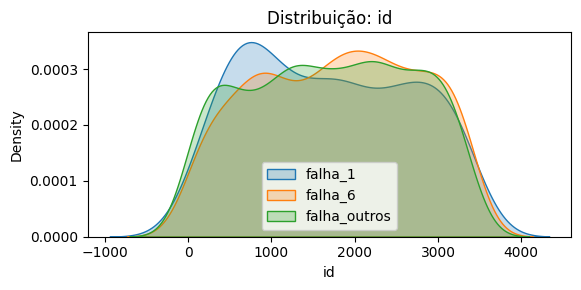

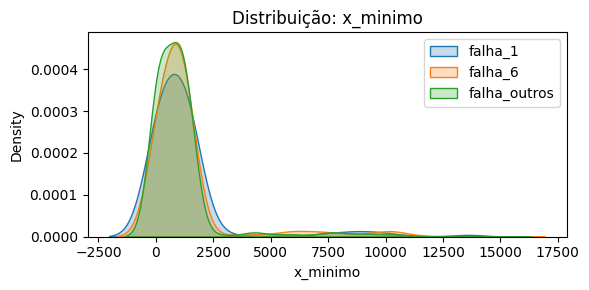

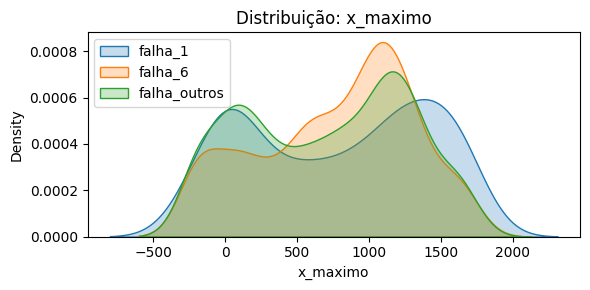

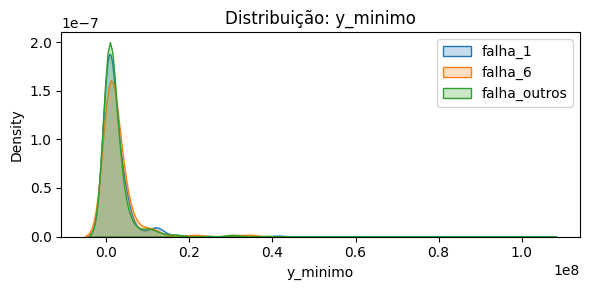

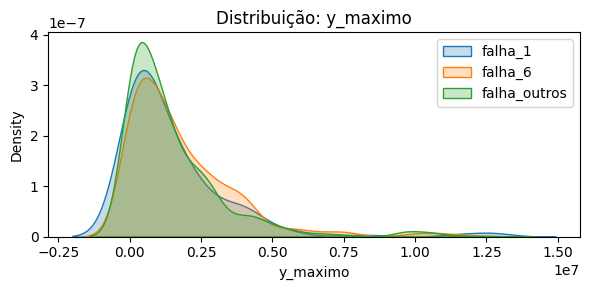

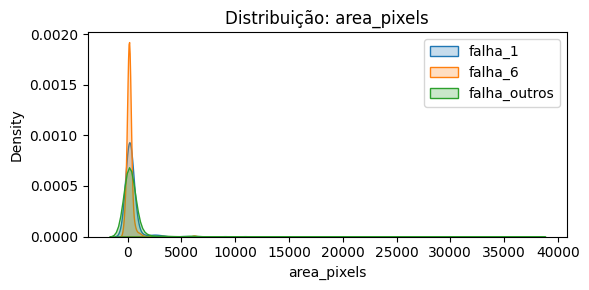

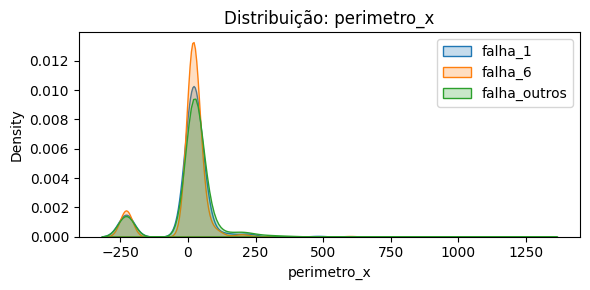

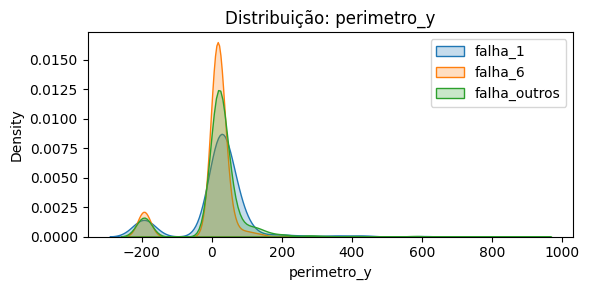

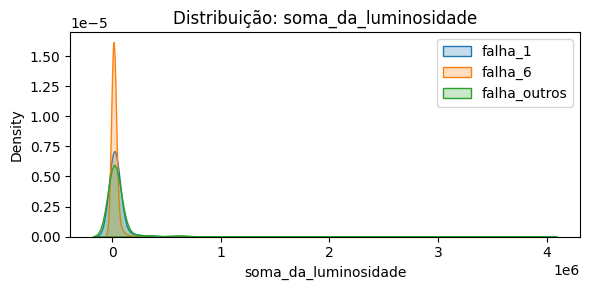

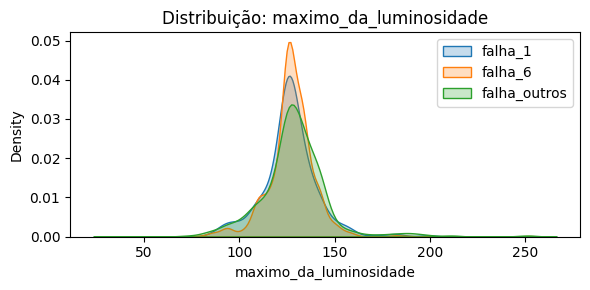

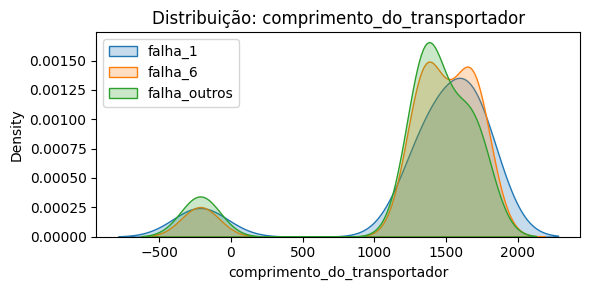

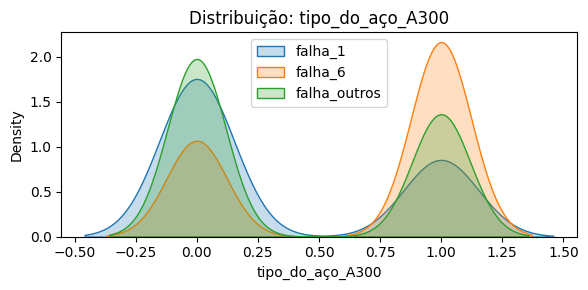

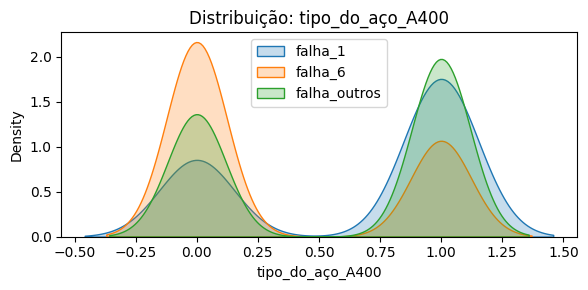

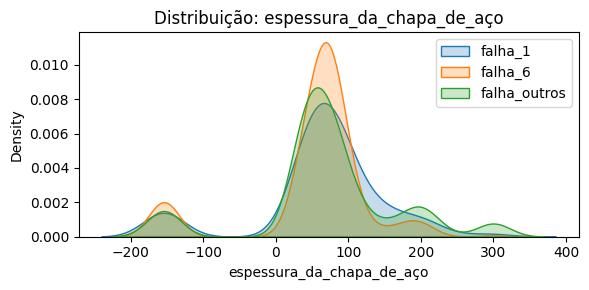

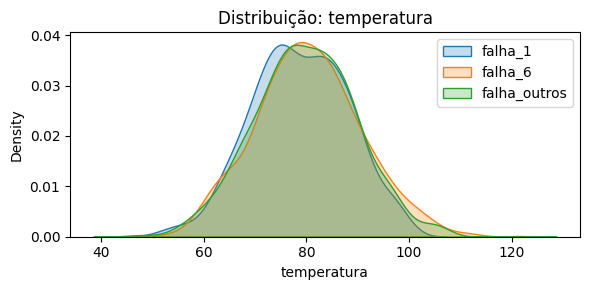

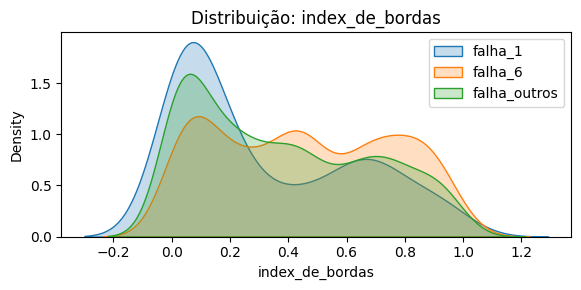

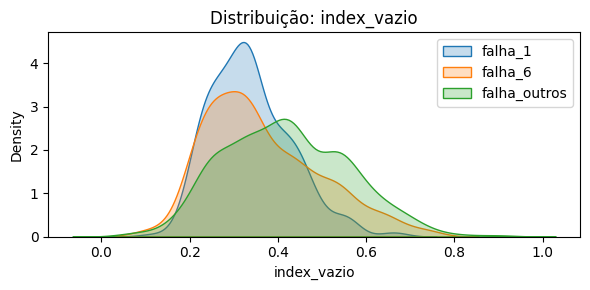

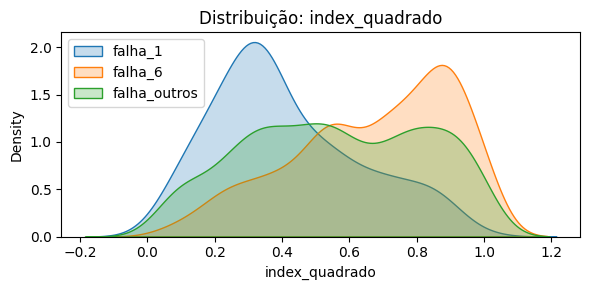

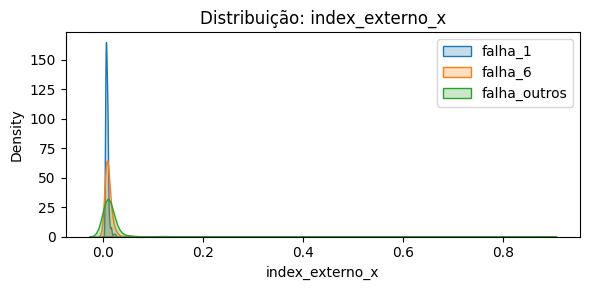

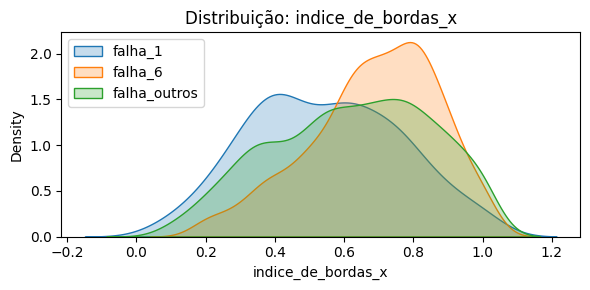

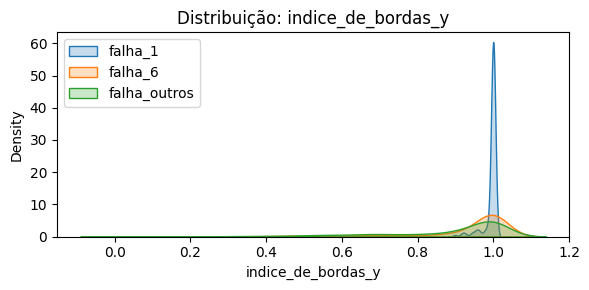

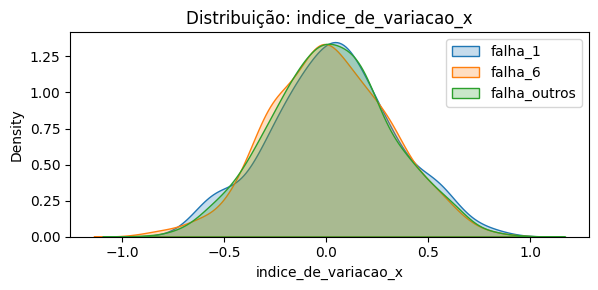

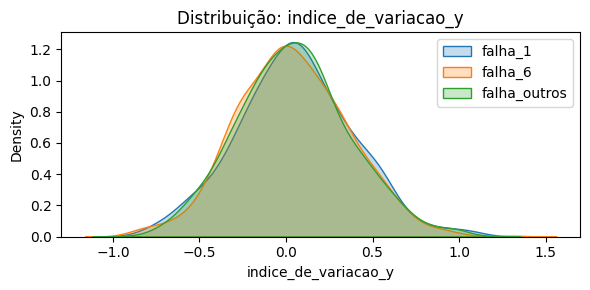

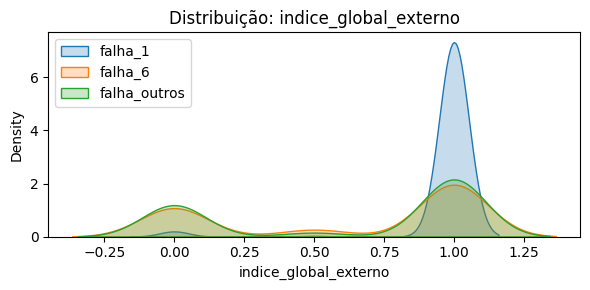

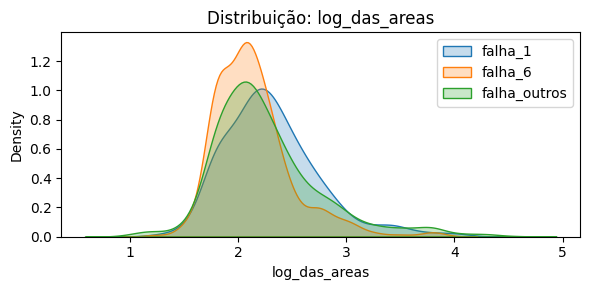

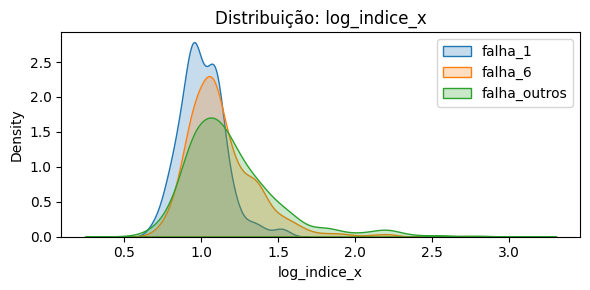

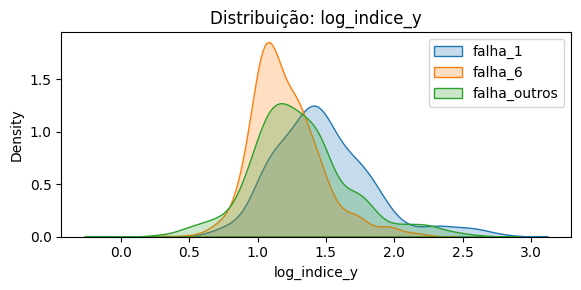

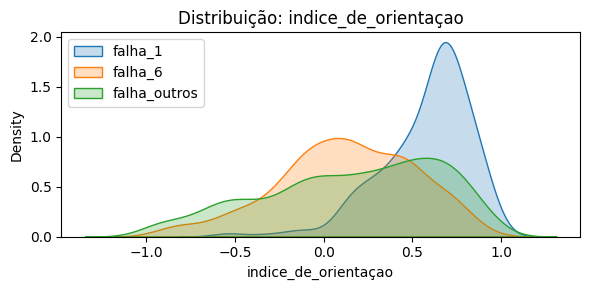

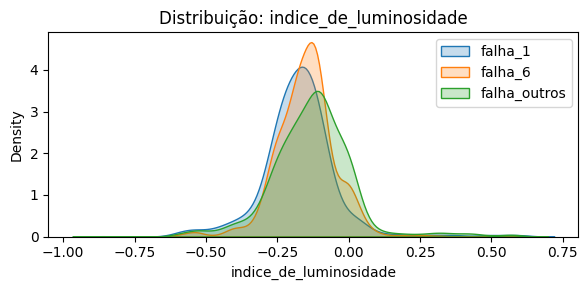

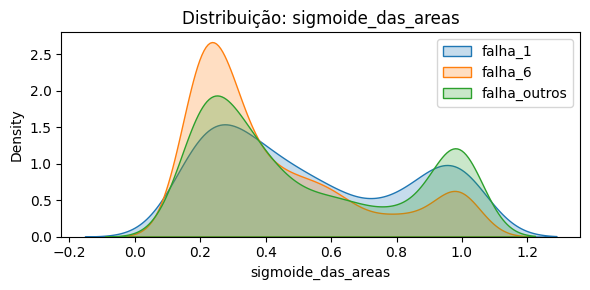

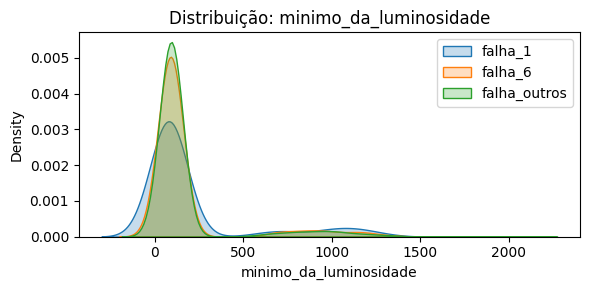

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_1'][col], label='falha_1', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore 

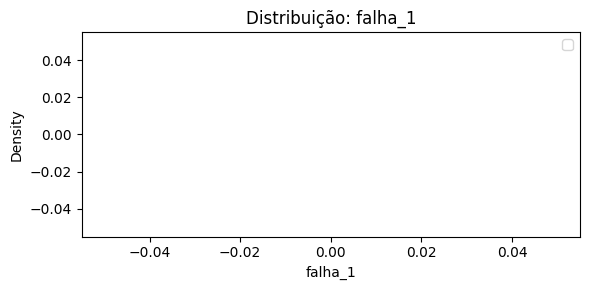

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_1'][col], label='falha_1', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore 

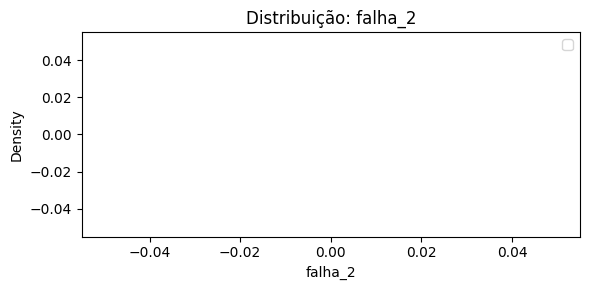

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_1'][col], label='falha_1', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore 

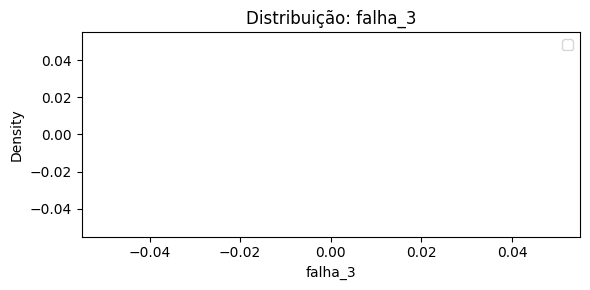

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_1'][col], label='falha_1', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore 

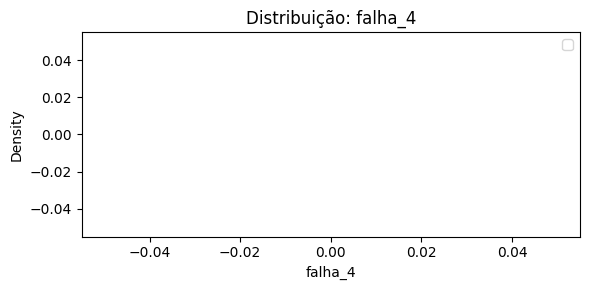

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_1'][col], label='falha_1', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore 

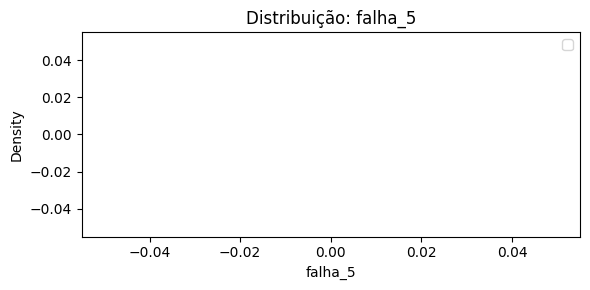

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_1'][col], label='falha_1', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore 

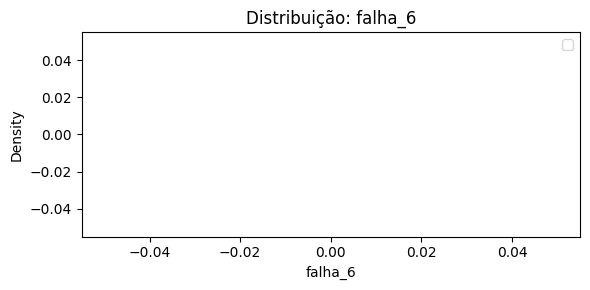

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_1'][col], label='falha_1', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3551496626.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore 

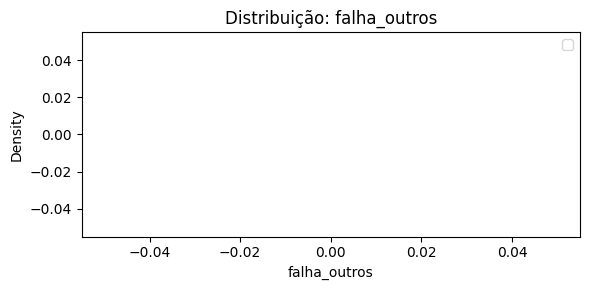

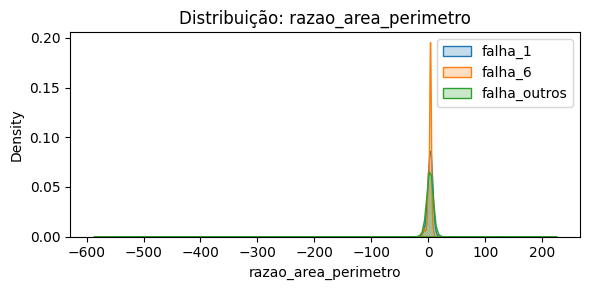

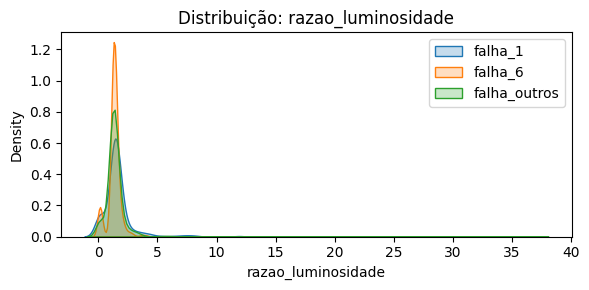

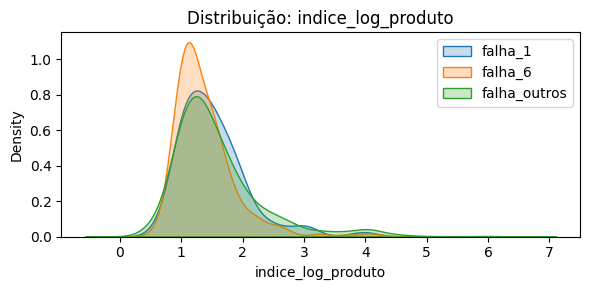

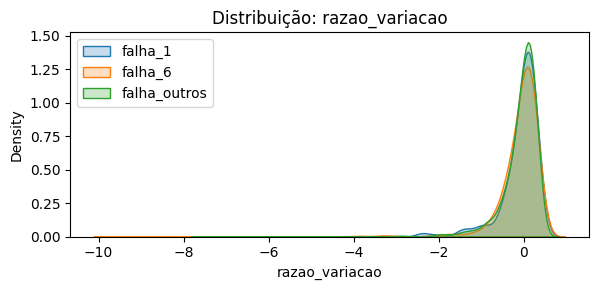

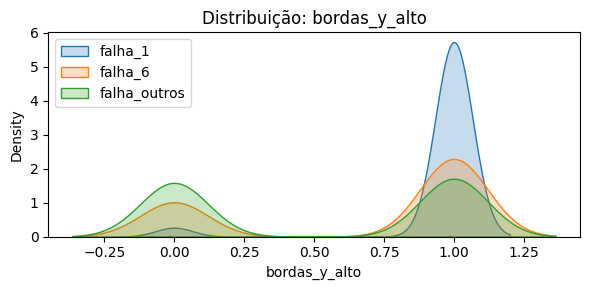

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# lista com todas as colunas numéricas
numericas = df.select_dtypes(include='number').columns.tolist()

# loop para gerar os gráficos
for col in numericas:
    plt.figure(figsize=(6, 3))
    try:
        sns.kdeplot(df[df['classe_defeito'] == 'falha_1'][col], label='falha_1', fill=True)
        sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
        sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
        plt.title(f'Distribuição: {col}')
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f" Erro na coluna {col}: {e}")

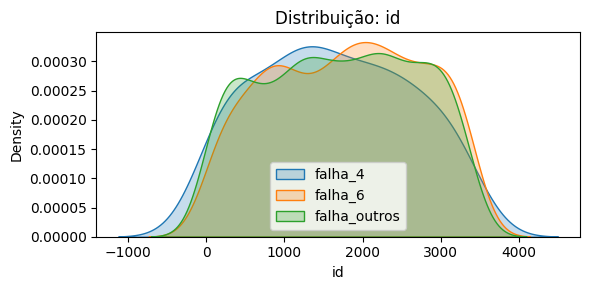

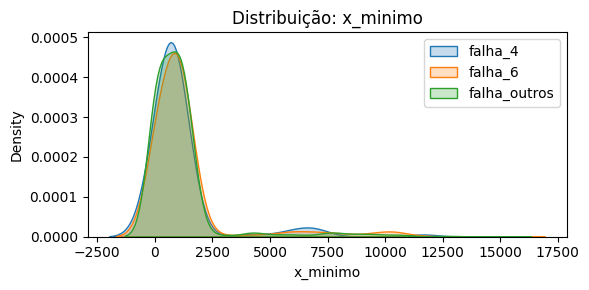

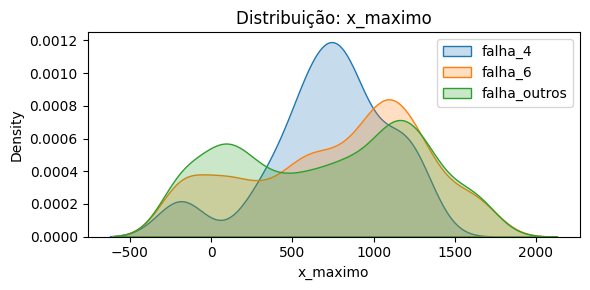

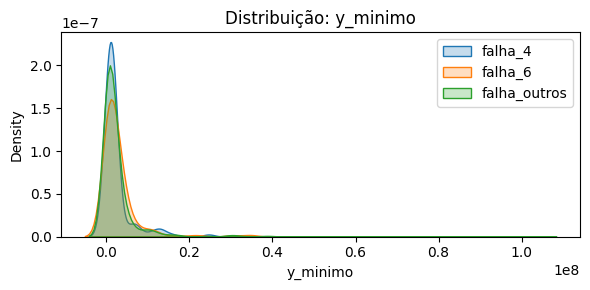

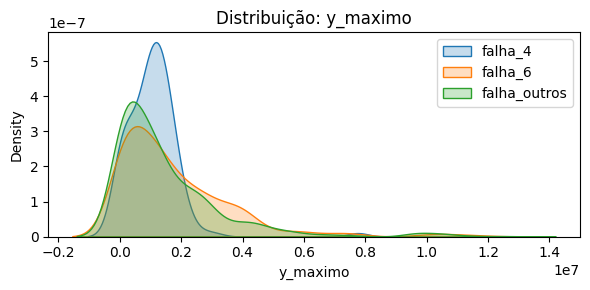

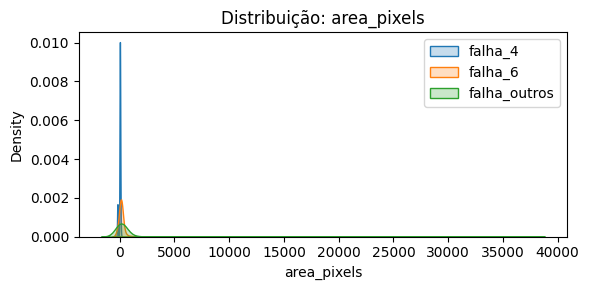

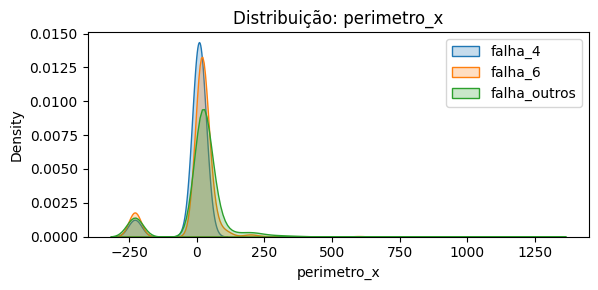

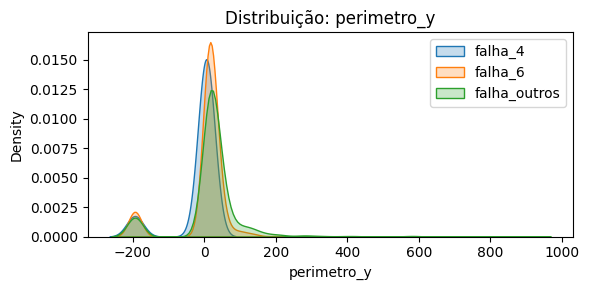

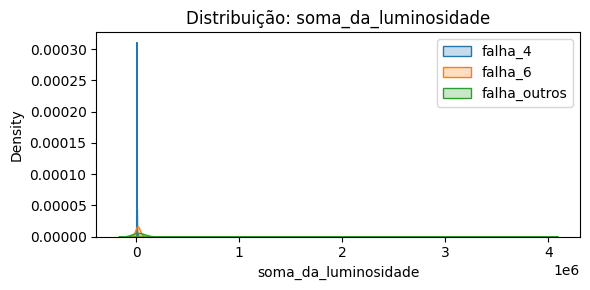

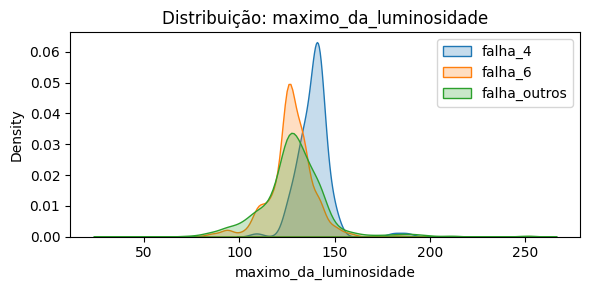

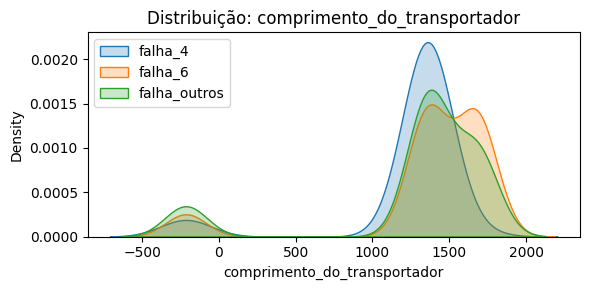

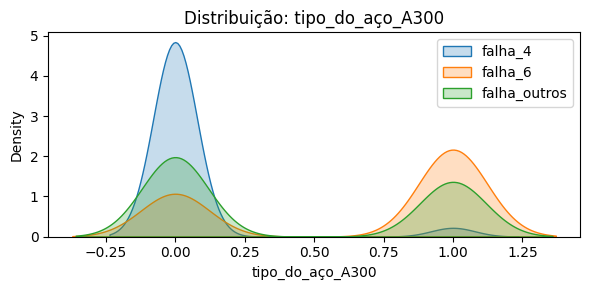

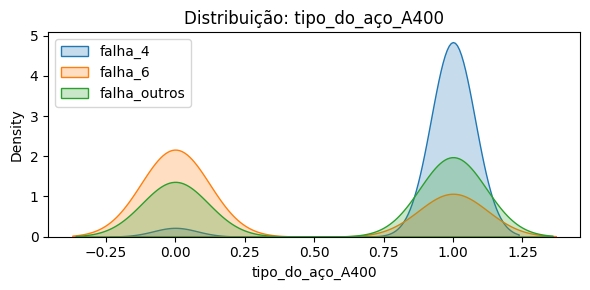

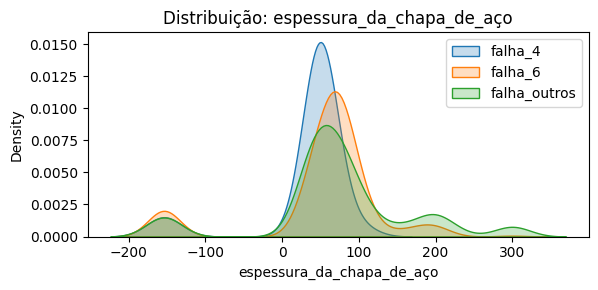

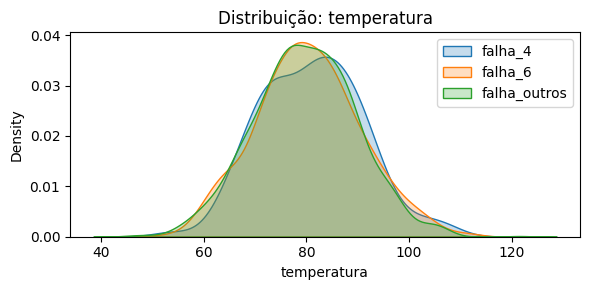

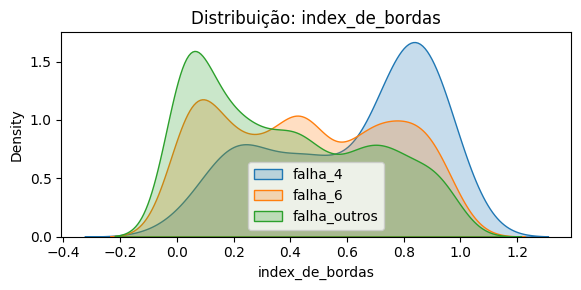

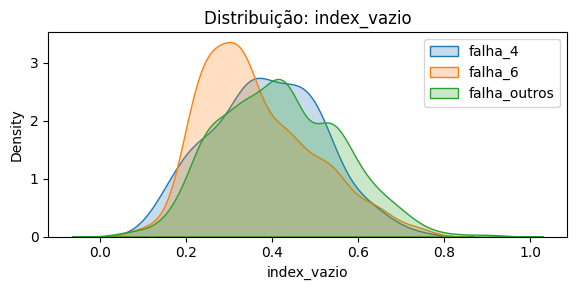

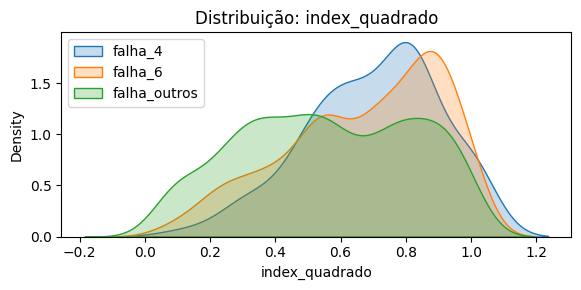

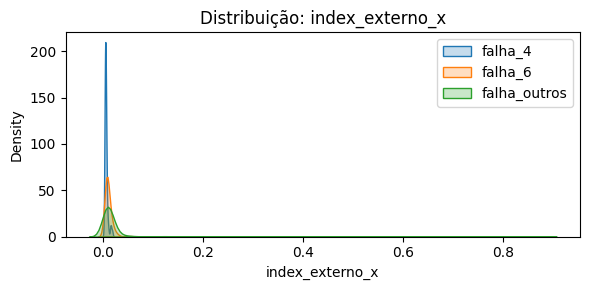

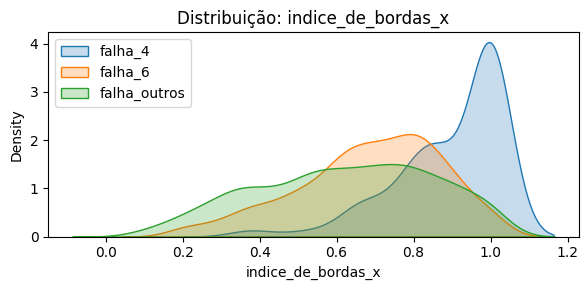

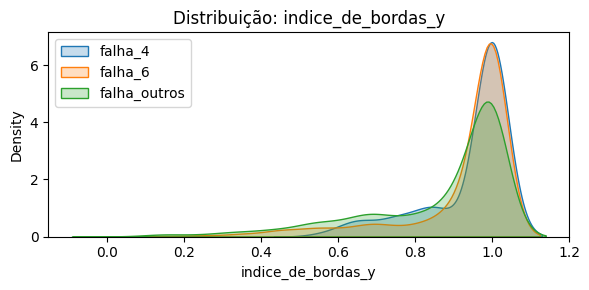

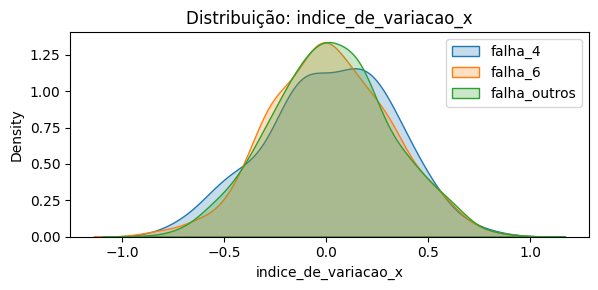

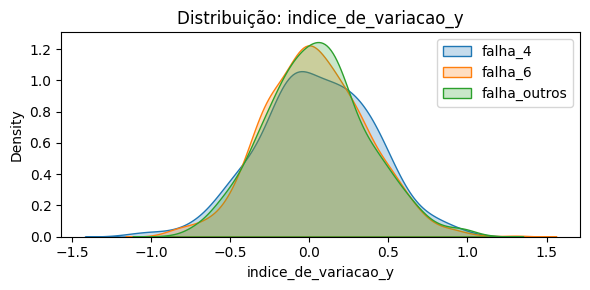

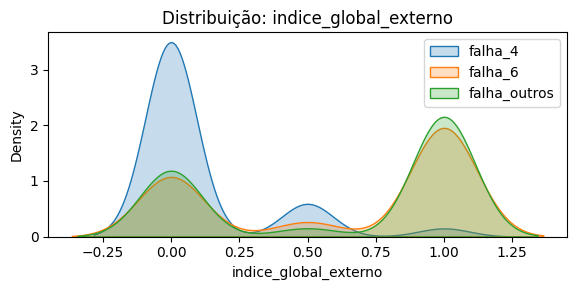

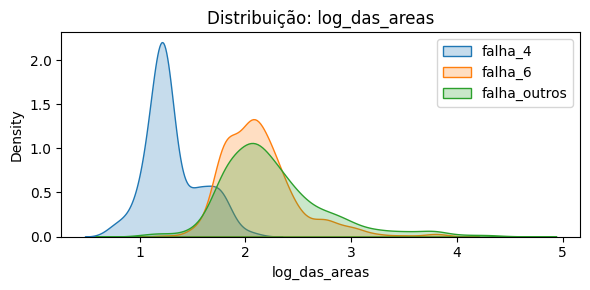

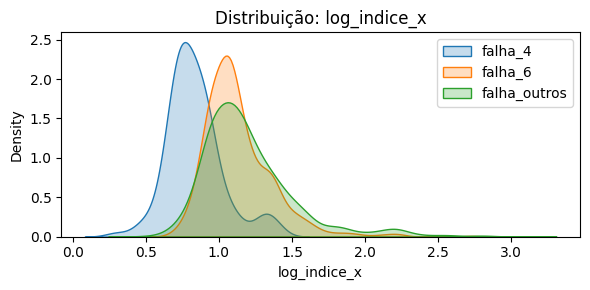

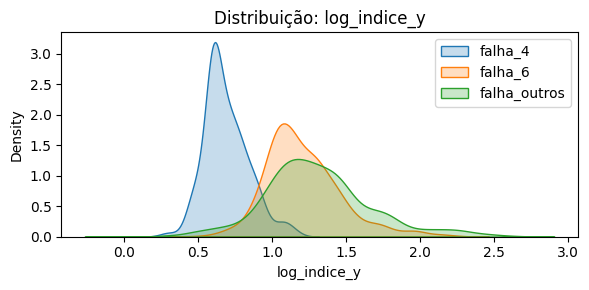

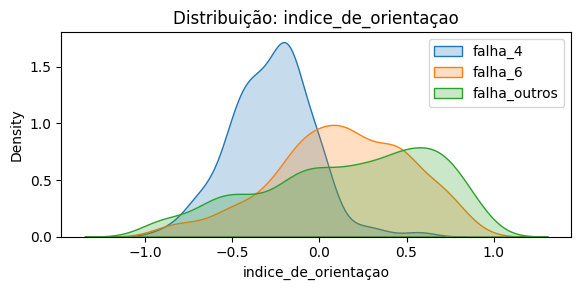

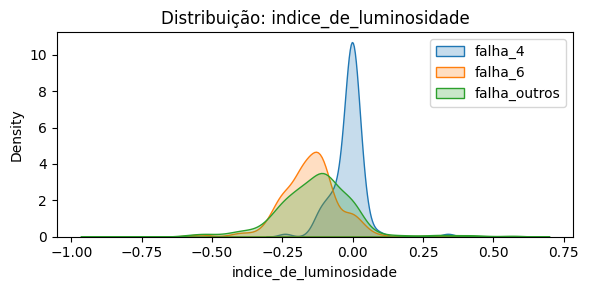

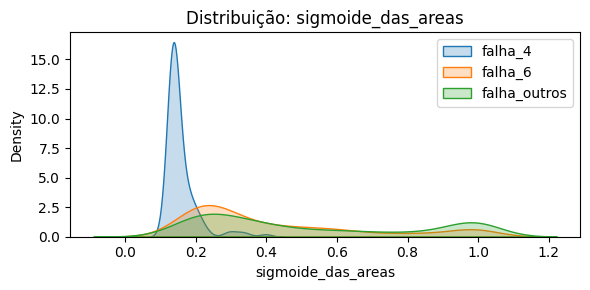

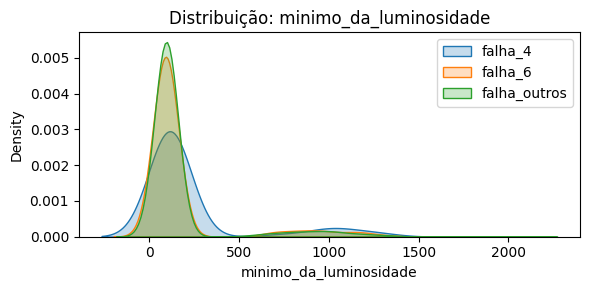

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_4'][col], label='falha_4', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are igno

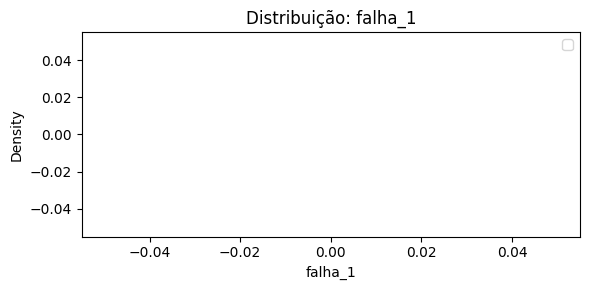

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_4'][col], label='falha_4', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are igno

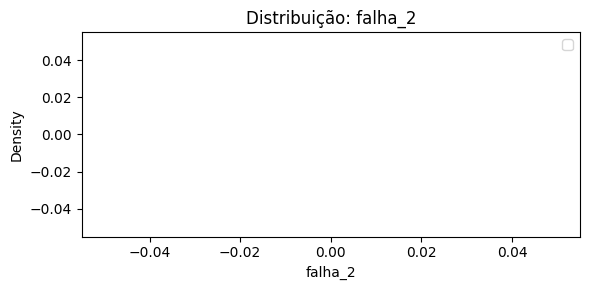

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_4'][col], label='falha_4', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are igno

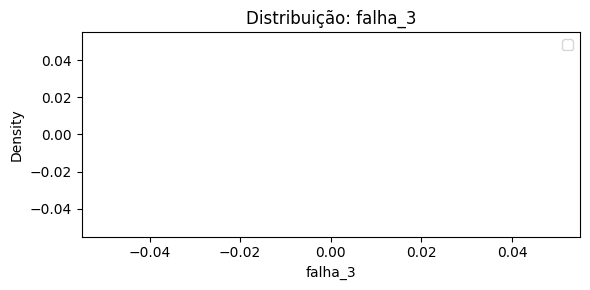

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_4'][col], label='falha_4', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are igno

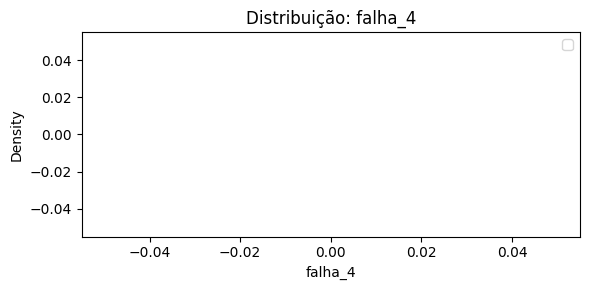

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_4'][col], label='falha_4', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are igno

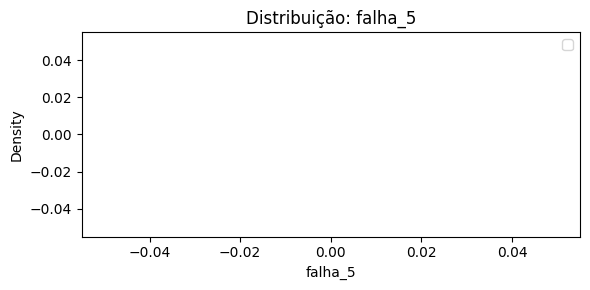

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_4'][col], label='falha_4', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are igno

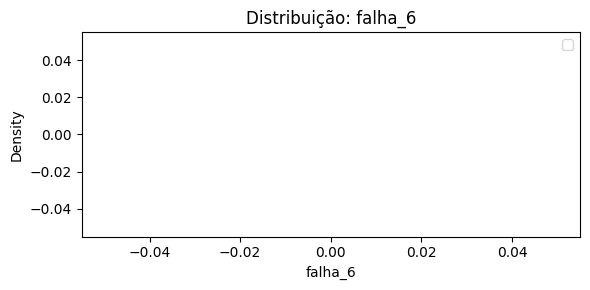

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_4'][col], label='falha_4', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\24491300.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are igno

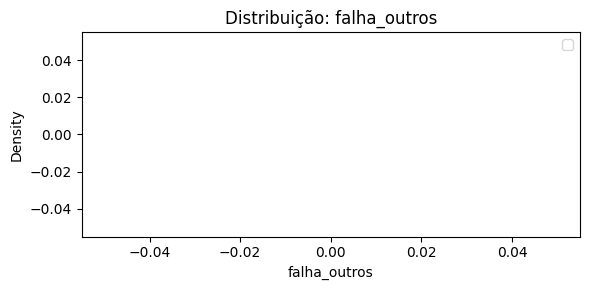

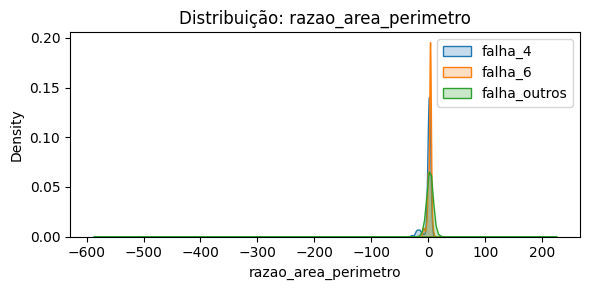

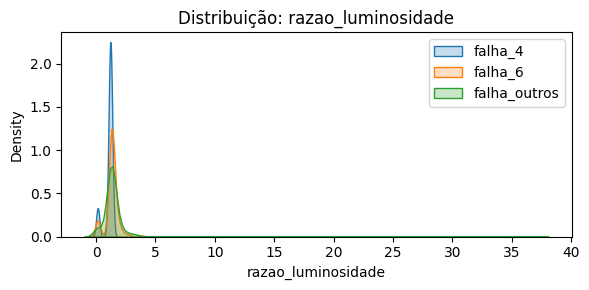

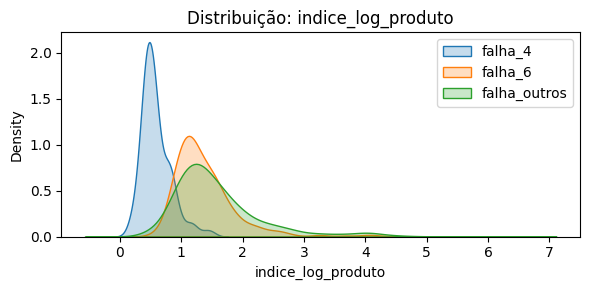

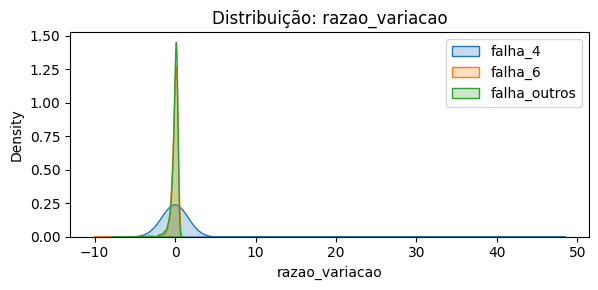

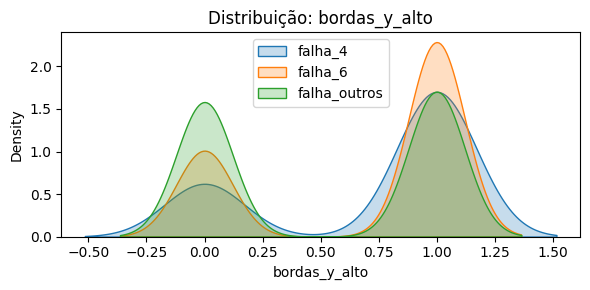

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# lista com todas as colunas numéricas, se ainda não tiver:
numericas = df.select_dtypes(include='number').columns.tolist()

# loop para gerar os gráficos
for col in numericas:
    plt.figure(figsize=(6, 3))
    try:
        sns.kdeplot(df[df['classe_defeito'] == 'falha_4'][col], label='falha_4', fill=True)
        sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
        sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
        plt.title(f'Distribuição: {col}')
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f" Erro na coluna {col}: {e}")

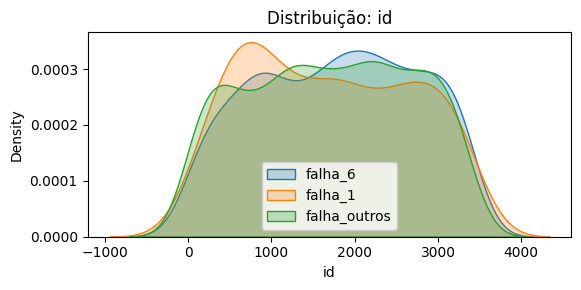

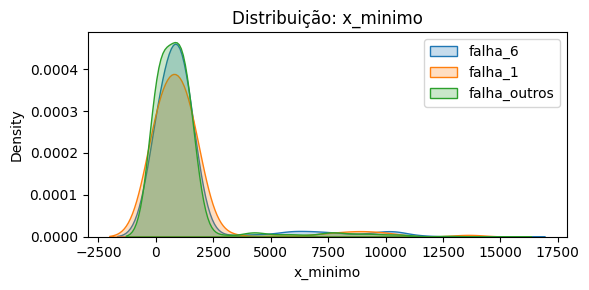

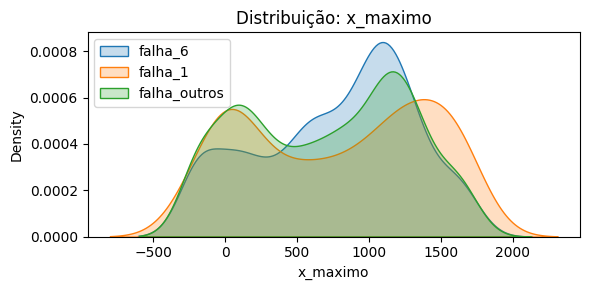

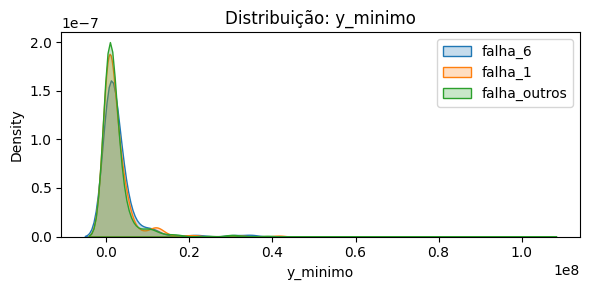

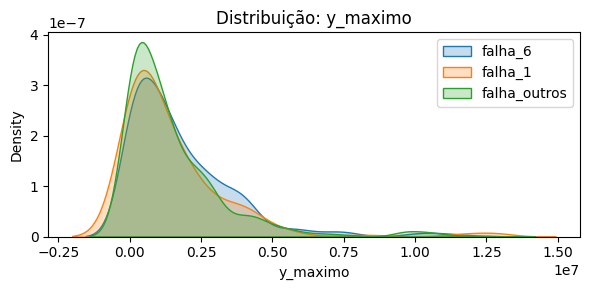

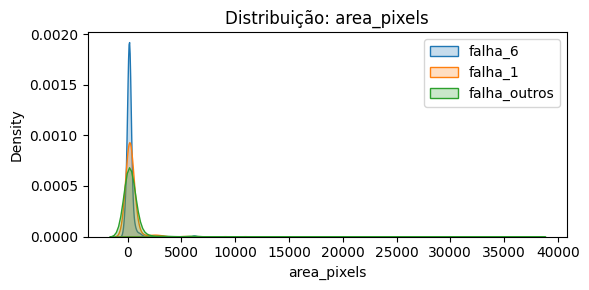

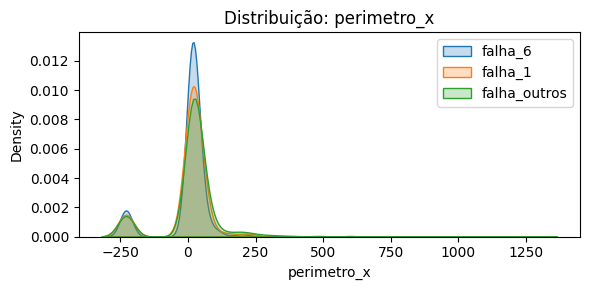

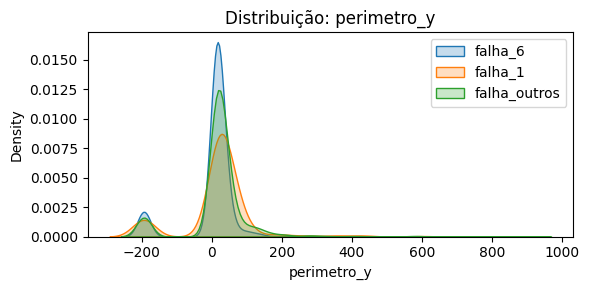

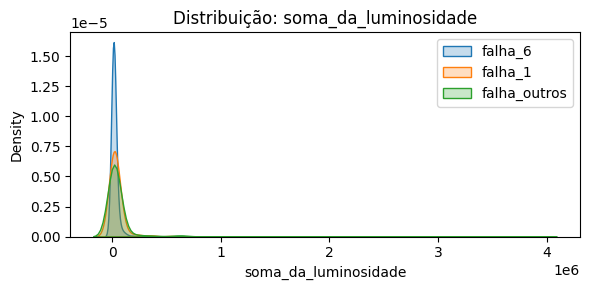

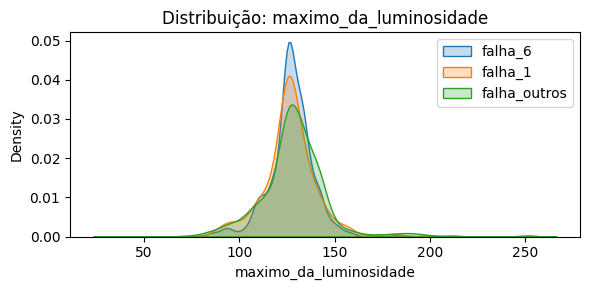

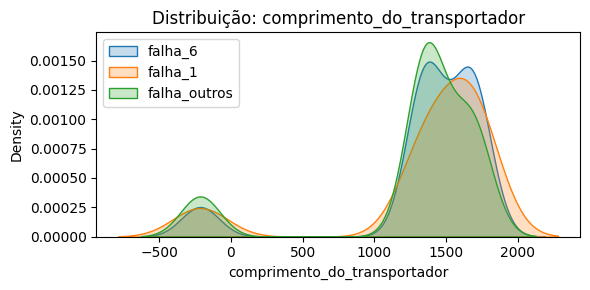

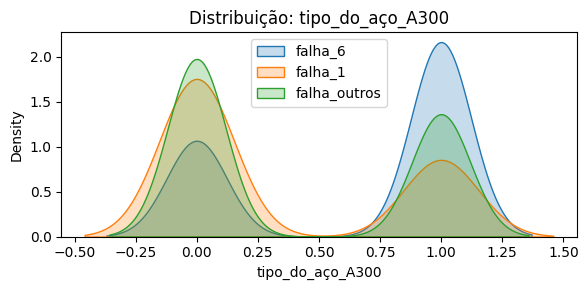

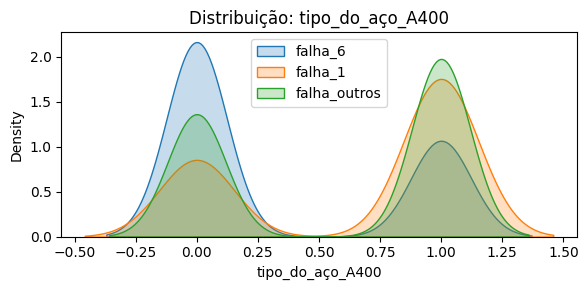

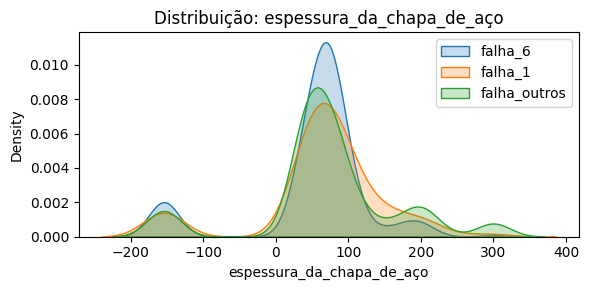

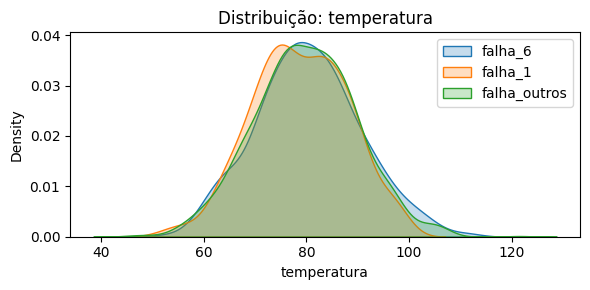

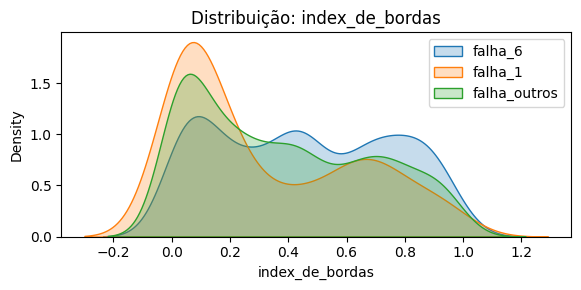

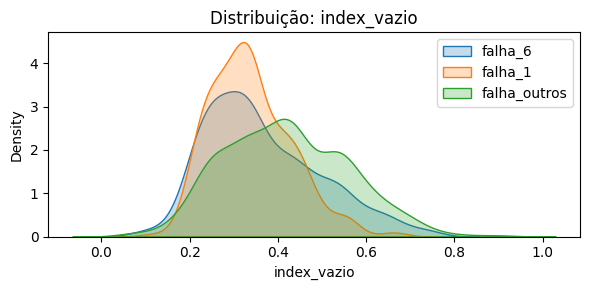

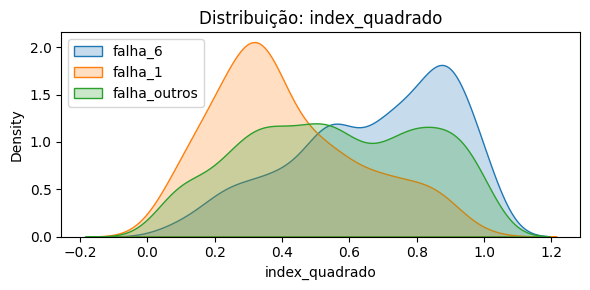

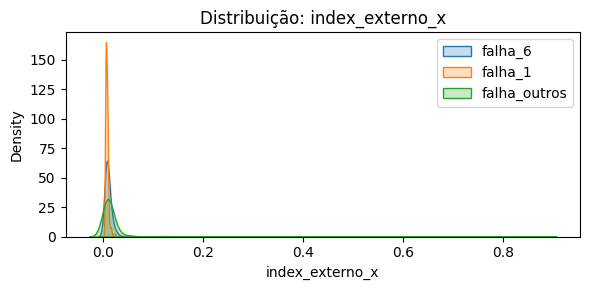

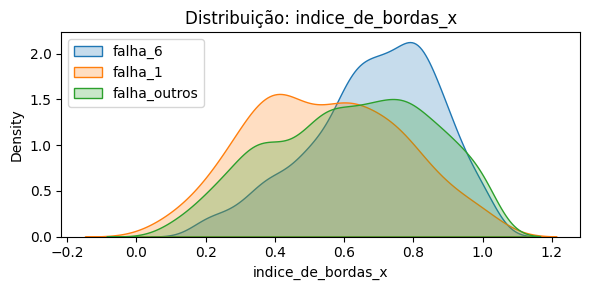

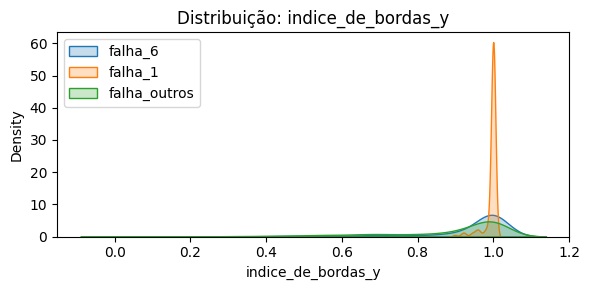

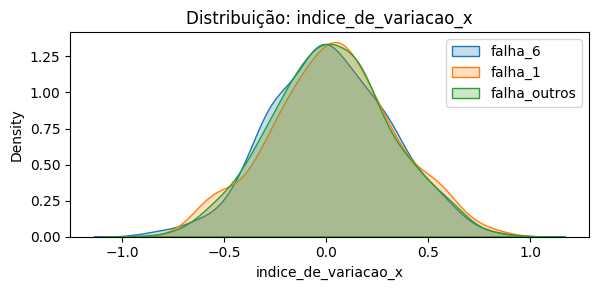

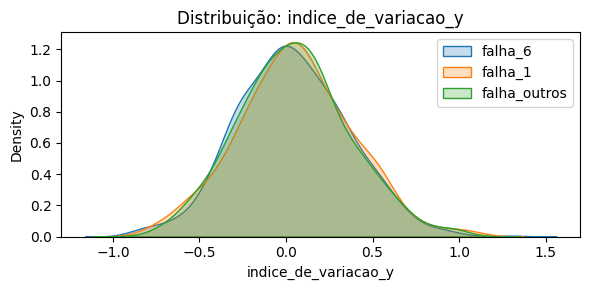

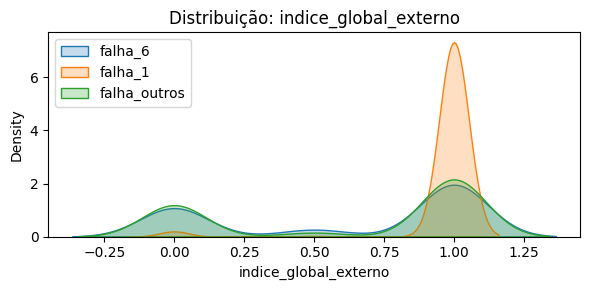

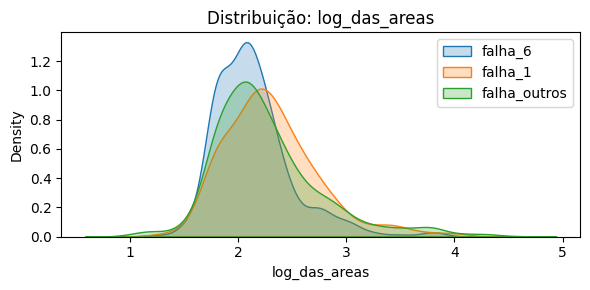

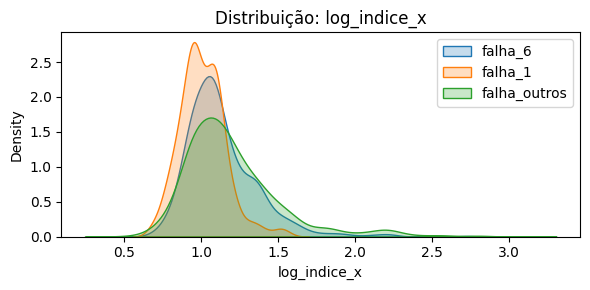

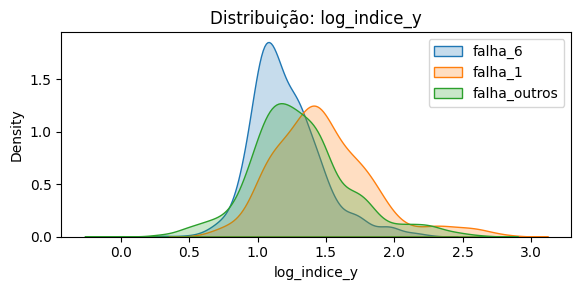

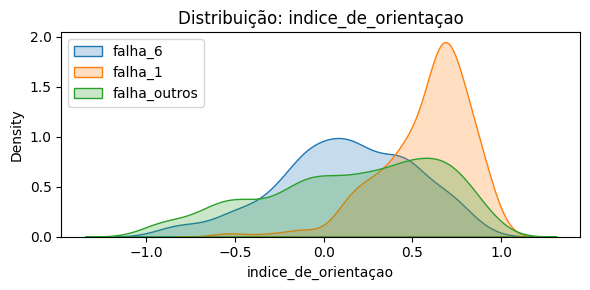

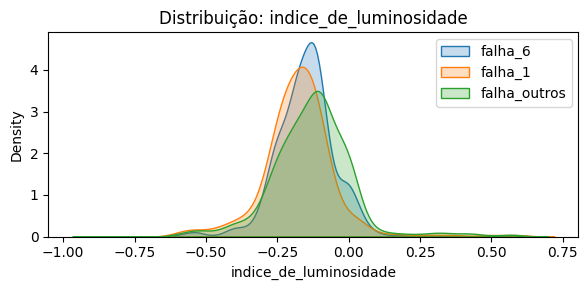

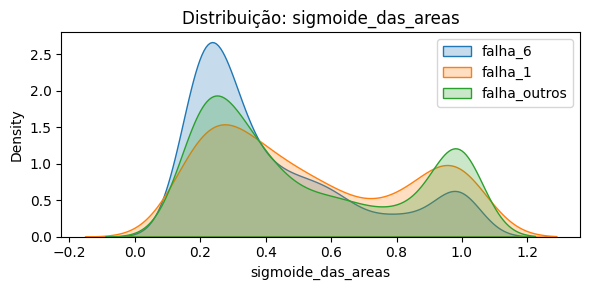

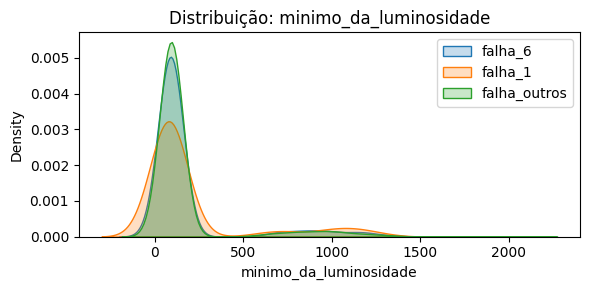

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_1'][col], label='falha_1', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ig

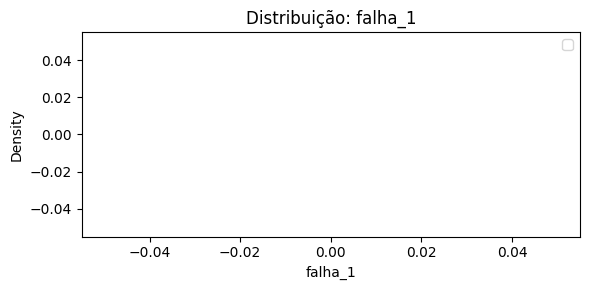

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_1'][col], label='falha_1', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ig

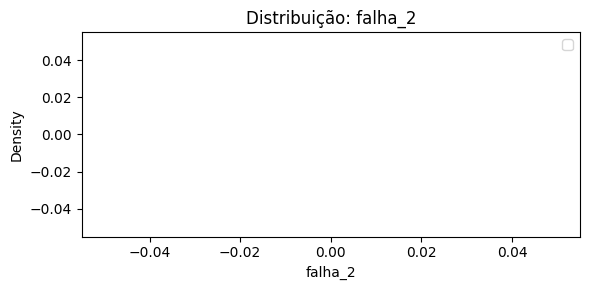

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_1'][col], label='falha_1', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ig

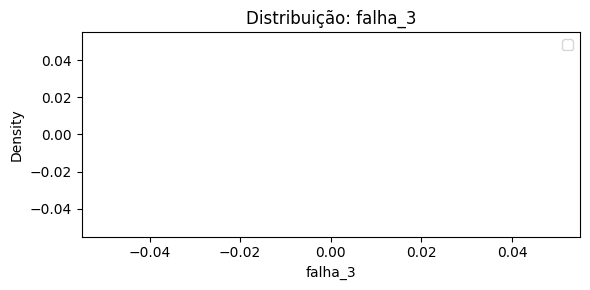

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_1'][col], label='falha_1', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ig

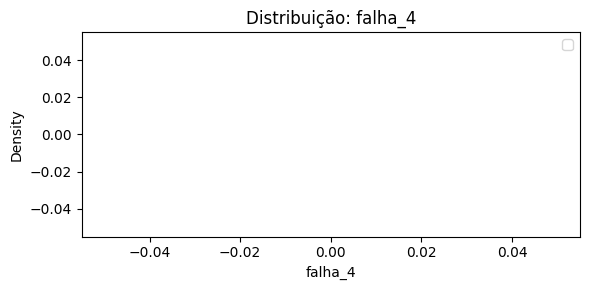

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_1'][col], label='falha_1', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ig

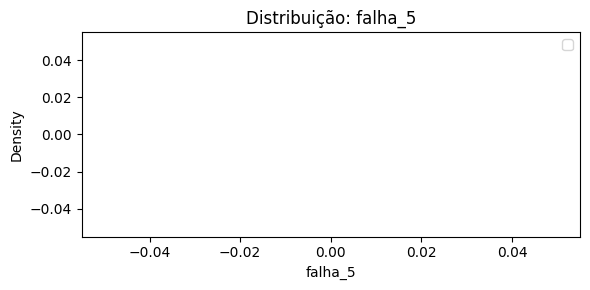

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_1'][col], label='falha_1', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ig

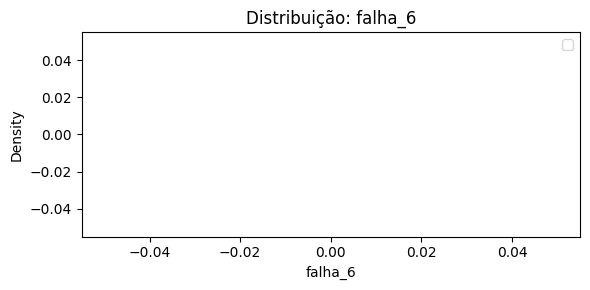

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_1'][col], label='falha_1', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\348061886.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ig

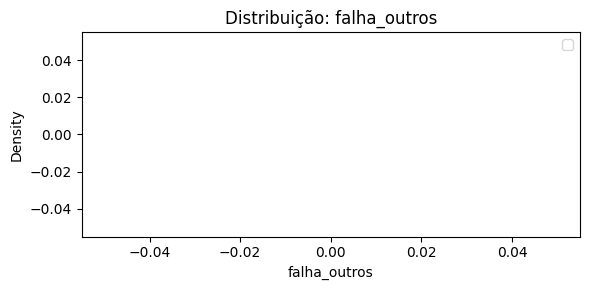

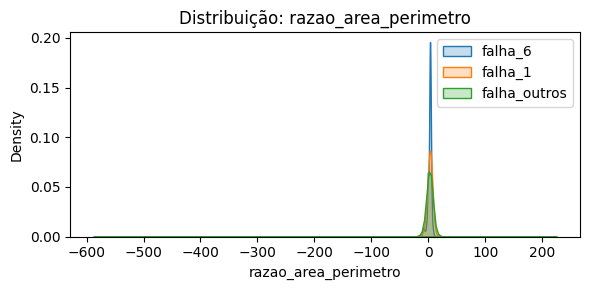

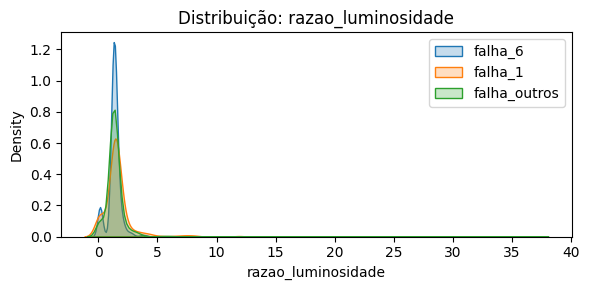

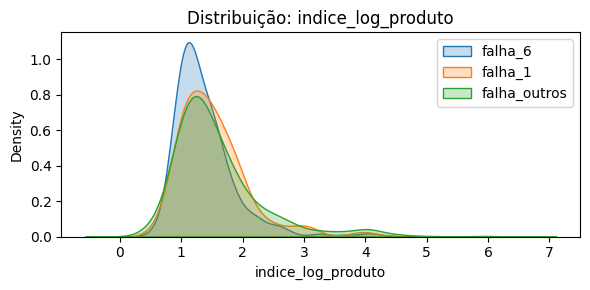

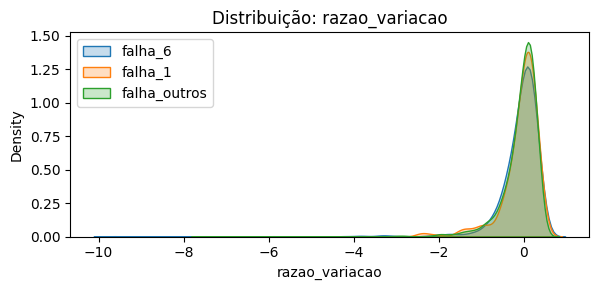

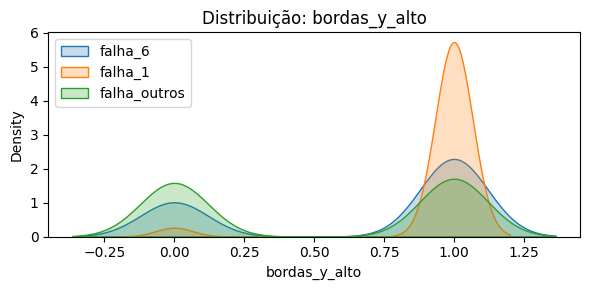

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# loop para gerar os gráficos
for col in numericas:
    plt.figure(figsize=(6, 3))
    try:
        sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
        sns.kdeplot(df[df['classe_defeito'] == 'falha_1'][col], label='falha_1', fill=True)
        sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
        plt.title(f'Distribuição: {col}')
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f" Erro na coluna {col}: {e}")

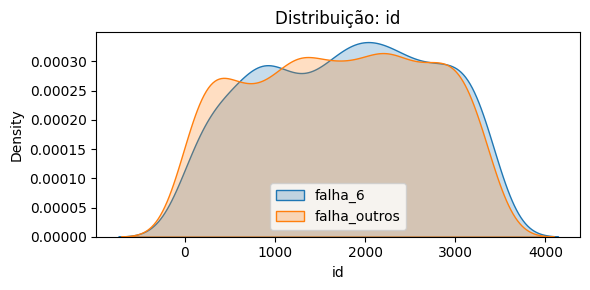

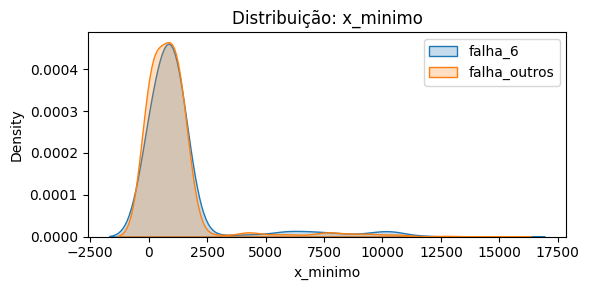

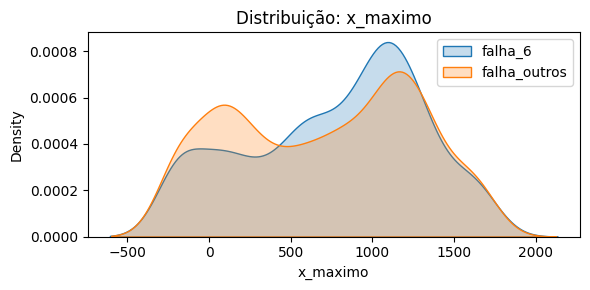

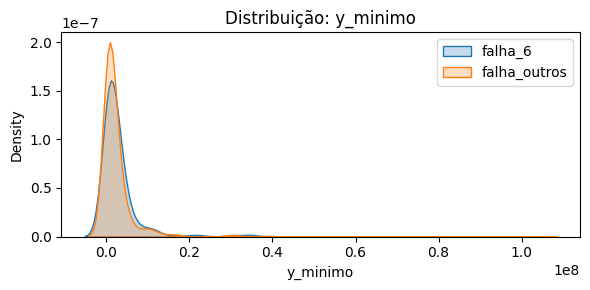

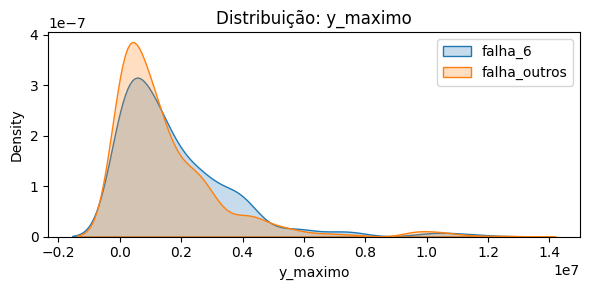

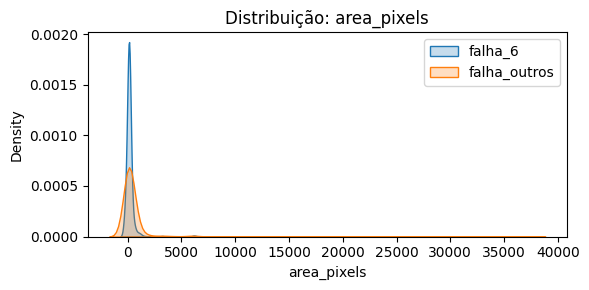

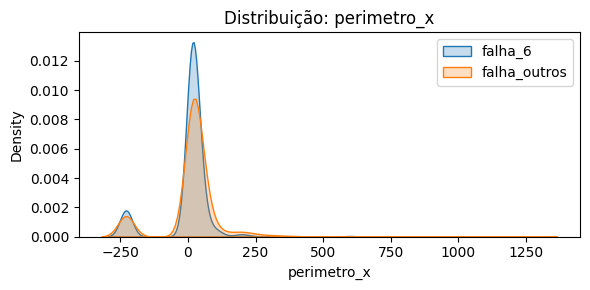

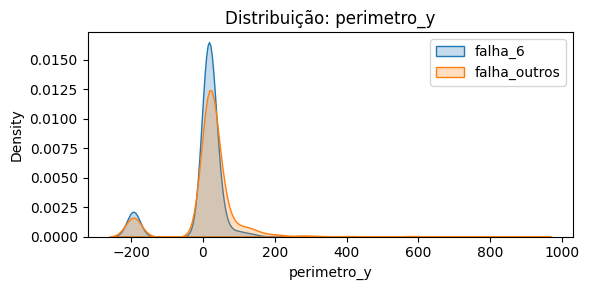

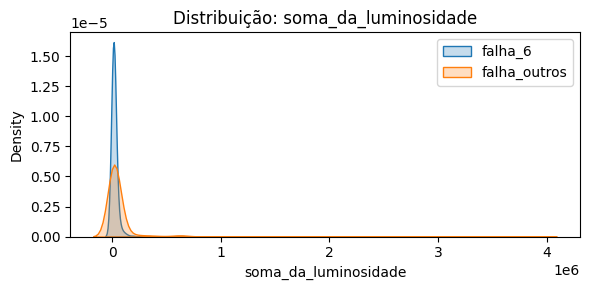

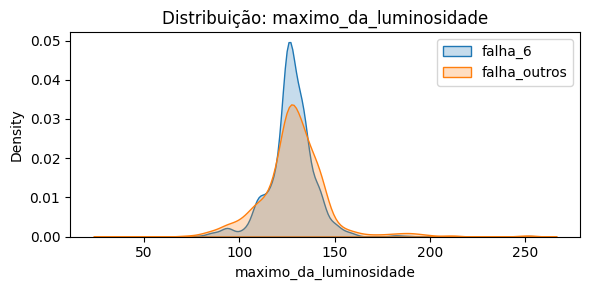

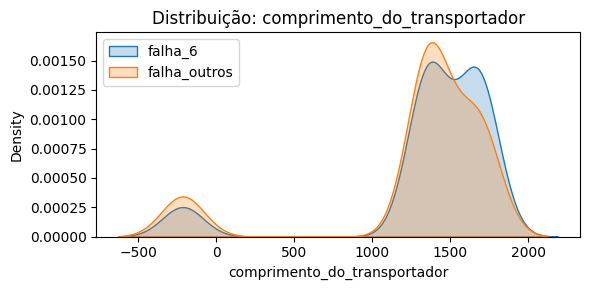

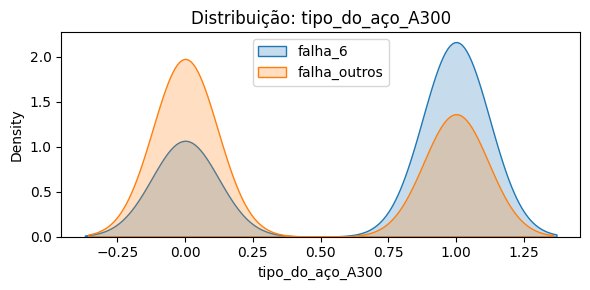

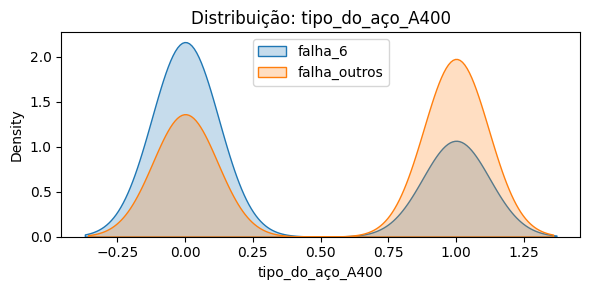

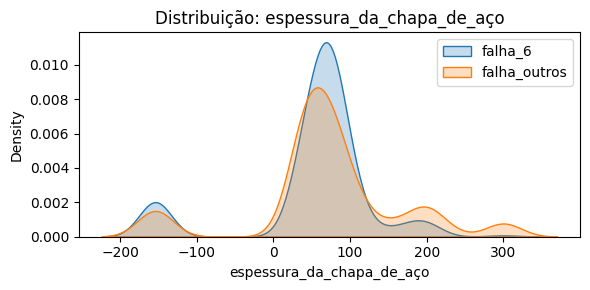

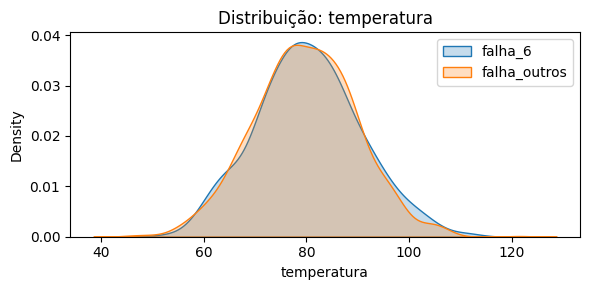

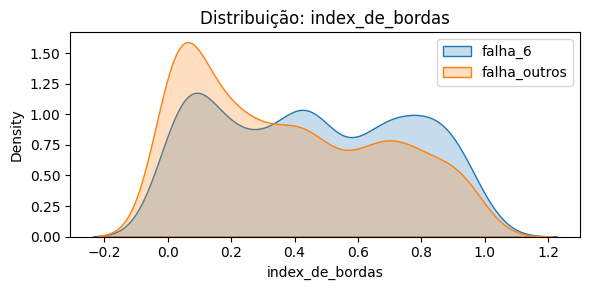

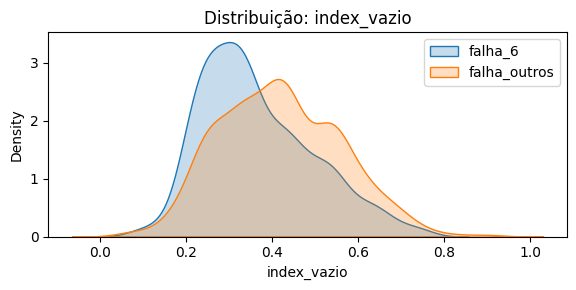

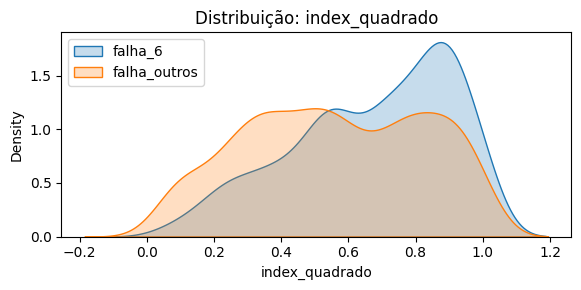

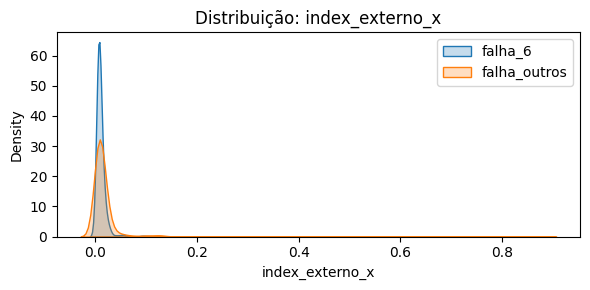

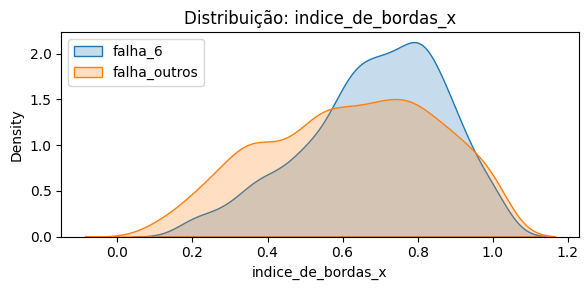

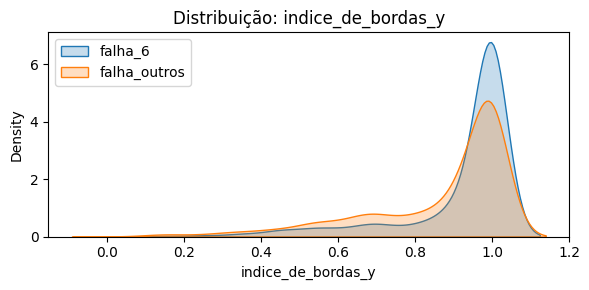

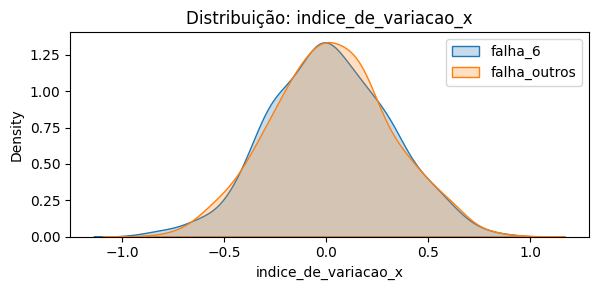

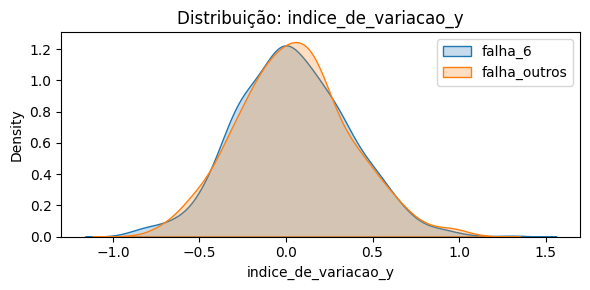

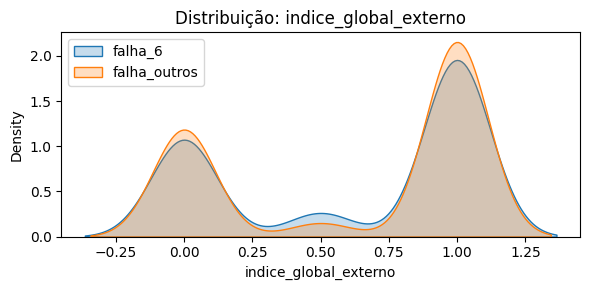

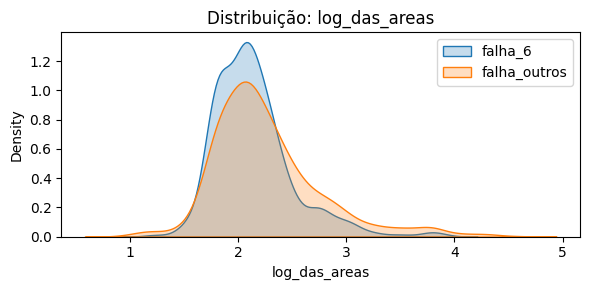

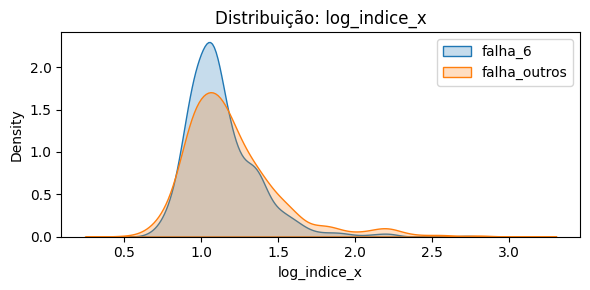

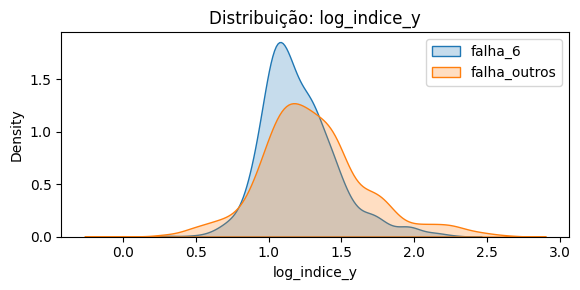

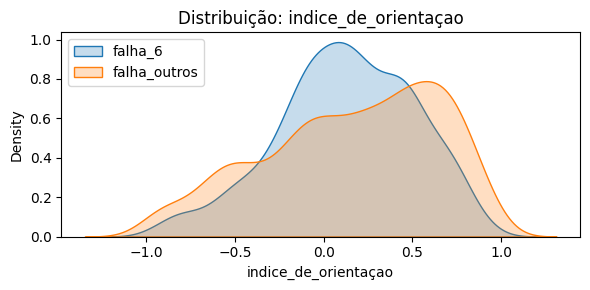

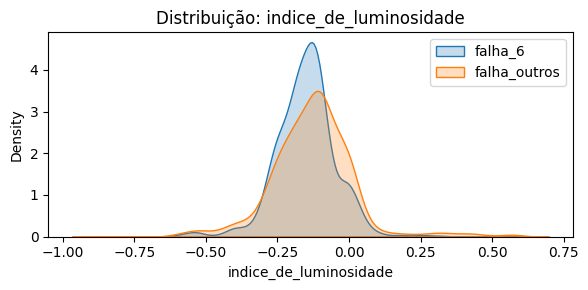

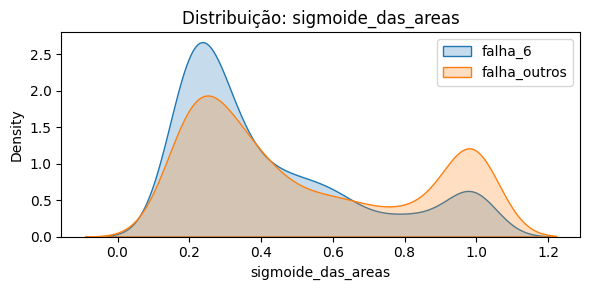

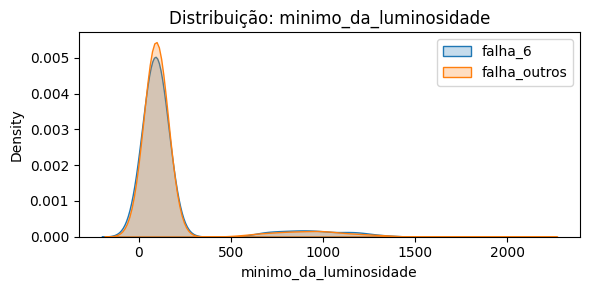

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3976600492.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3976600492.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3976600492.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


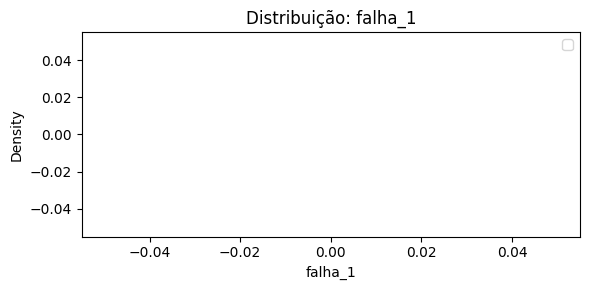

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3976600492.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3976600492.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3976600492.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


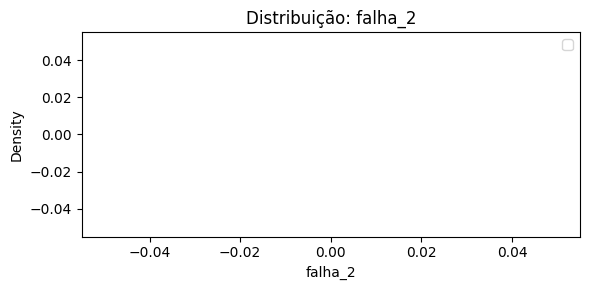

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3976600492.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3976600492.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3976600492.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


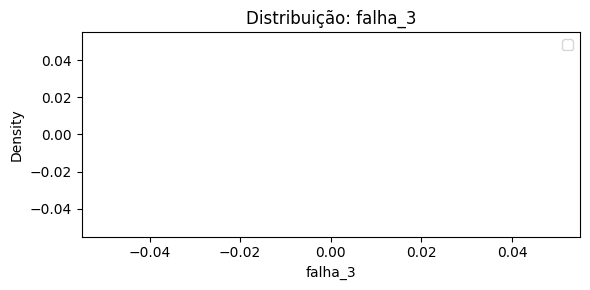

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3976600492.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3976600492.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3976600492.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


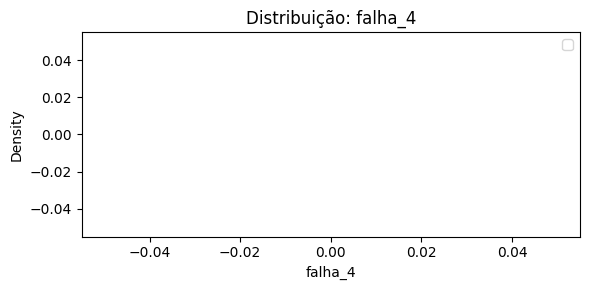

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3976600492.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3976600492.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3976600492.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


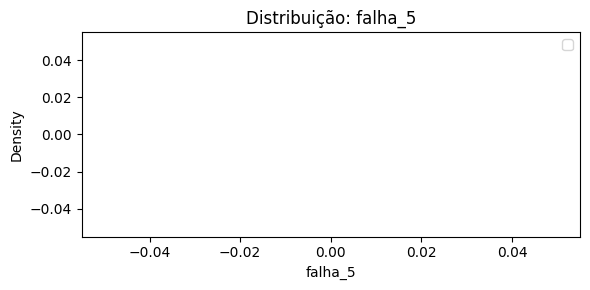

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3976600492.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3976600492.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3976600492.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


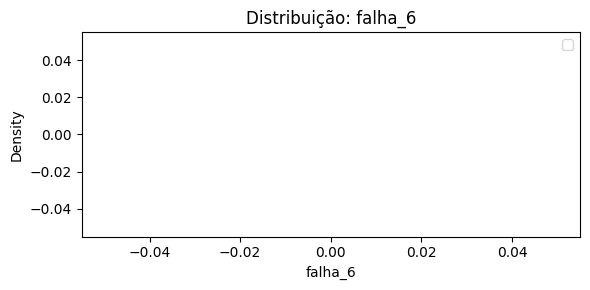

C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3976600492.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3976600492.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
C:\Users\natha\AppData\Local\Temp\ipykernel_4596\3976600492.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


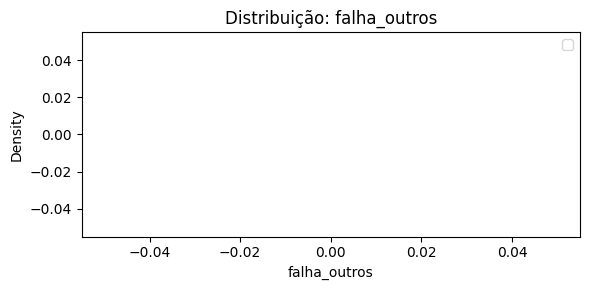

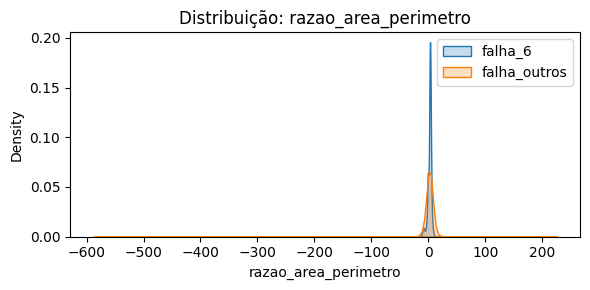

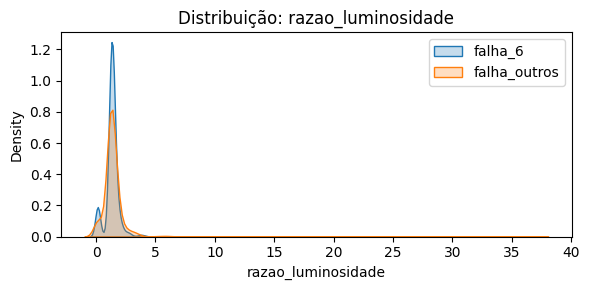

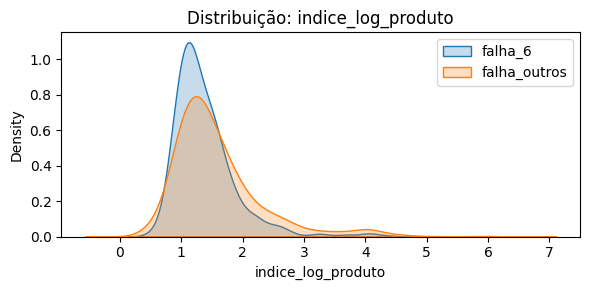

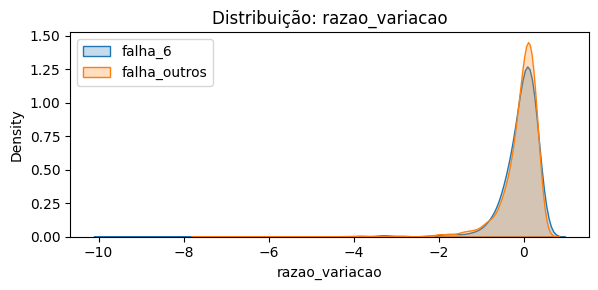

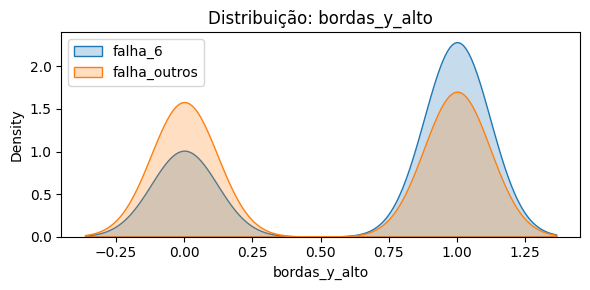

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# lista com todas as colunas numéricas, se ainda não tiver:
numericas = df.select_dtypes(include='number').columns.tolist()

# loop para gerar os gráficos
for col in numericas:
    plt.figure(figsize=(6, 3))
    try:
        sns.kdeplot(df[df['classe_defeito'] == 'falha_6'][col], label='falha_6', fill=True)
        sns.kdeplot(df[df['classe_defeito'] == 'falha_outros'][col], label='falha_outros', fill=True)
        plt.title(f'Distribuição: {col}')
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f" Erro na coluna {col}: {e}")

## Teste

In [13]:
df_teste = pd.read_csv('C:/Users/natha/Downloads/RES_IA/data/bootcamp_test.csv')

# Calcula as novas features, assim como no treino
df_teste['razao_area_perimetro'] = df_teste['area_pixels'] / (df_teste['perimetro_x'] + df_teste['perimetro_y'] + 1)
df_teste['razao_luminosidade'] = df_teste['maximo_da_luminosidade'] / (df_teste['minimo_da_luminosidade'] + 1)
df_teste['indice_log_produto'] = df_teste['log_indice_x'] * df_teste['log_indice_y']
df_teste['razao_variacao'] = df_teste['indice_de_variacao_x'] / (df_teste['indice_de_variacao_y'] + 1)
df_teste['bordas_y_alto'] = (df_teste['indice_de_bordas_y'] > 0.95).astype(int)

# Visualiza a estrutura
df_teste.info()

# O ID vai ser usado no final para a submissão
ids = df_teste['id']
# Recebe o dataframe completo, exceto os rotulos
X_teste = df_teste

# aplica o modelo treinado no conjunto de teste
y_pred_label = melhor_xgb.predict(X_teste) # são os rotulos numéricos previstos
y_pred_classe = label_encoder.inverse_transform(y_pred_label) # converte os números de volta para os nomes

# cria um dataframe de colunas binárias e preenche com 1 apenas na classe prevista de cada amostra
df_resultado = pd.DataFrame(0, index=range(len(y_pred_classe)), columns=[
    'falha_1', 'falha_2', 'falha_3', 'falha_4', 'falha_5', 'falha_6', 'falha_outros'
])
for i, classe in enumerate(y_pred_classe):
    df_resultado.loc[i, classe] = 1

# adiciona a coluna de id
df_resultado.insert(0, 'id', ids)

# exporta o resultado em CSV e imprime uma mensagem de confirmação
df_resultado.to_csv('../outputs/submissao_final.csv', index=False)
print("Arquivo 'submissao_final.csv' gerado com sucesso!")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            389 non-null    int64  
 1   x_minimo                      389 non-null    int64  
 2   x_maximo                      389 non-null    int64  
 3   y_minimo                      389 non-null    int64  
 4   y_maximo                      389 non-null    int64  
 5   peso_da_placa                 389 non-null    int64  
 6   area_pixels                   389 non-null    int64  
 7   perimetro_x                   389 non-null    int64  
 8   perimetro_y                   389 non-null    int64  
 9   soma_da_luminosidade          389 non-null    int64  
 10  maximo_da_luminosidade        389 non-null    int64  
 11  comprimento_do_transportador  389 non-null    int64  
 12  tipo_do_aço_A300              389 non-null    int64  
 13  tipo_

In [16]:
import joblib

# Salvar o modelo treinado
joblib.dump(melhor_xgb, "../scripts/modelo_xgboost.pkl")

# Salvar o LabelEncoder
joblib.dump(label_encoder, "../scripts/label_encoder.pkl")

['../scripts/label_encoder.pkl']